<a href="https://colab.research.google.com/github/splAcharya/Extractive_Text_Summarization/blob/main/ExTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extractive Text Summarization Of Wikipedia Articles

## Install Packages (if needed)

In [1]:
#gensim
!pip install --upgrade gensim

#rouge scorer
!pip install rouge-score

     |████████████████████████████████| 24.1 MB 2.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


## Import Required Libraries

In [2]:
import time
import re
import urllib.request
from bs4 import BeautifulSoup as bs

import string
pm_set = set(list(string.punctuation))

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
sw_set = set(stopwords.words("english"))

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
import gensim.downloader
from gensim.models import Phrases

import multiprocessing
num_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {num_cores}")

from wordcloud import WordCloud
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from sklearn.utils.extmath import randomized_svd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD as LSA, LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans

from copy import deepcopy
from rouge_score import rouge_scorer
import pandas as pd
from collections import Counter, defaultdict


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Number of Cores: 2


## Function to Webscrape Wikipedia Article

In [3]:
def fetch_wikipedia_article(url="https://en.wikipedia.org/wiki/USA"):
    scrapped_data = urllib.request.urlopen(url)
    article = scrapped_data.read()
    parsed_article = bs(article,"lxml")
    paragraphs = parsed_article.find_all("p")
    article_text = ""
    for p in paragraphs:
        article_text += p.text
    return article_text

## Function to Pre-process Web Scraped Wikipedia Article

In [4]:
def preprocess_article(article, min_length = 5):
    article_lc = article.lower()#lower case entire article
    article_st = sent_tokenize(article_lc)#convert to sentences
    lmtzr = WordNetLemmatizer()#instantiate lemmatize
    pp_article_st = []
    final_article_st = []
    for sentence in article_st:
        original_sentence = deepcopy(sentence)
        #print(sentence)
        sentence = re.sub(r"[\(.*\)]"," ", sentence)#remove data betweena nd include round backers()
        #print(sentence)
        sentence = re.sub(r"\n","",sentence) #remove "\n" characters
        #print(sentence)
        sentence = re.sub(r"\[\d+\]"," ",sentence)#remove refrences [n]
        #print(sentence)
        sentence = re.sub(r"\[.+\]"," ",sentence) #remove anything between [] including []
        #print(sentence)
        sentence = re.sub(r"[^a-zA-z0-9]", " ", sentence) #remove any non english characters
        #print(sentence)
        sentence = re.sub(r"\s+"," ",sentence) #remove any whitespaces, tabs, newline charaacters
        #print(sentence)
        sentence = [lmtzr.lemmatize(word) for word in word_tokenize(sentence) if word not in sw_set ]
        if len(sentence) >= min_length:
            sentence = (" ").join(sentence)
            pp_article_st.append(sentence)
            final_article_st.append(original_sentence)
    return final_article_st, pp_article_st

## Using the two function above to extract Wikipedia Article about USA

In [5]:
article_text = fetch_wikipedia_article("https://en.wikipedia.org/wiki/USA")
article_st, pp_article_st = preprocess_article(article_text)
pp_article_st_wt = [word_tokenize(sent) for sent in pp_article_st]

In [6]:
pp_string = (" ").join(pp_article_st)

In [7]:
article_st[0]

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.'

In [8]:
pp_article_st[0:5]

['coordinate mw parser output geo default mw parser output geo dm mw parser output geo dec display inline mw parser output geo nondefault mw parser output geo multi punct display none mw parser output longitude mw parser output latitude white space nowrap 40 n 100 w 40 n 100 w 40 100the united state america u usa commonly known united state u u america country primarily located north america',
 'consists 50 state federal district five major unincorporated territory 326 indian reservation nine minor outlying island',
 'nearly 3 8 million square mile 9 8 million square kilometer world third fourth largest country geographic area',
 'united state share land border canada north mexico south well maritime border bahamas cuba russia country',
 'national capital washington c populous city financial center new york city']

In [10]:
article_text

'\n\nCoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°N 100°W\ufeff / \ufeff40°N 100°W\ufeff / 40; -100\nThe United States of America (U.S.A. or USA), commonly known as the United States (U.S. or US) or America, is a country primarily located in North America. It consists of 50 states, a federal district, five major unincorporated territories, 326 Indian reservations, and nine minor outlying islands.[h] At nearly 3.8\xa0million square miles (9.8\xa0million square kilometers), it is the world\'s third- or fourth-largest country by geographic area.[c] The United States shares land borders with Canada to the north and Mexico to the south as well as maritime borders with the Bahamas, Cuba, Russia, and other countries.[i] With a population of more than 331 million peopl

## Generate Word Clouds For Raw and Preprocessed Wikipedia Article about USA

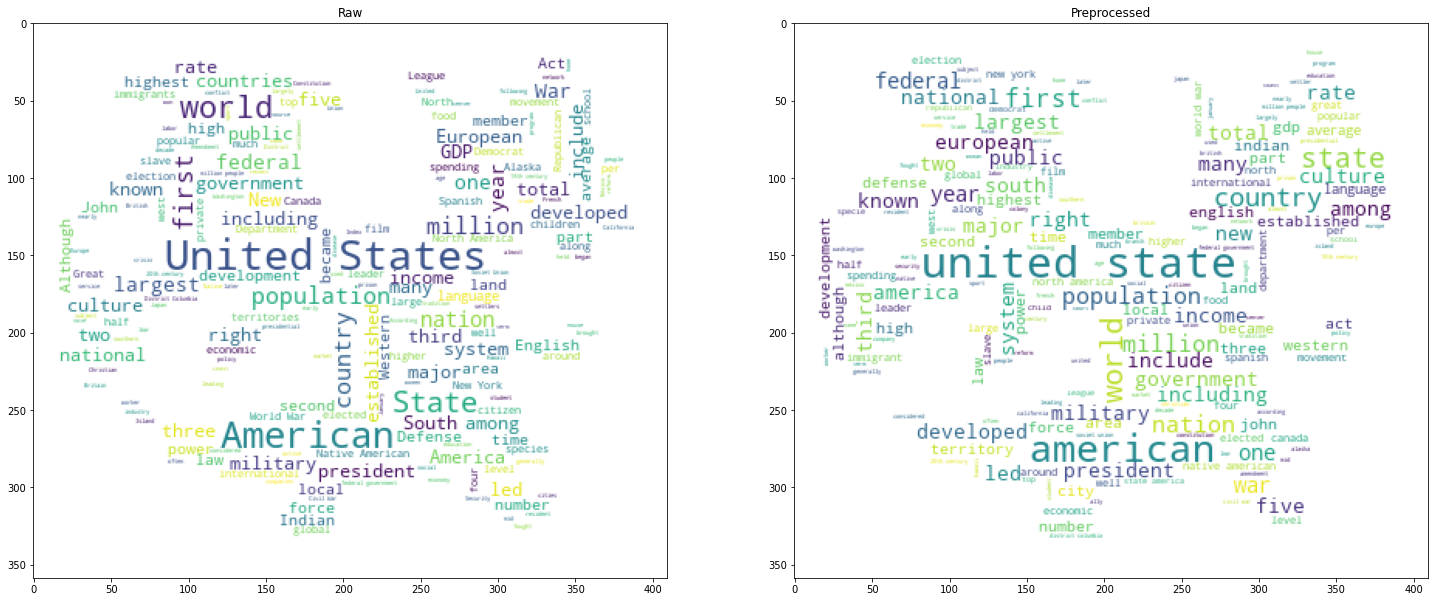

In [11]:
wc_mask = np.array(Image.open(urllib.request.urlopen("http://pm1.narvii.com/5750/abb7fdf1f24f9515a1f1d16e6f05d3f03110c51f_00.jpg")))
wc = WordCloud(background_color="white",mask=wc_mask)
fig, ax = plt.subplots(1,2,figsize=(25,25))
ax[0].imshow(wc.generate(article_text))
ax[0].title.set_text("Raw")
ax[1].imshow(wc.generate(pp_string))
ax[1].title.set_text("Preprocessed")
plt.show()

## LSA Summary Generators

### Function to Generate BOW + LSA Summary

In [12]:
def generate_bow_lsa_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple)
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens)
  U, SIGMA, VT = randomized_svd(feature_vector, n_components = summary_size, n_iter = 100, random_state =100)
  sentence_scores = np.sqrt(np.dot(U**2, SIGMA**2))
  top_scores_index = np.argsort(sentence_scores)[::-1]
  top_scores_index = top_scores_index[0:summary_size]
  article_array = np.array(raw_sent_tokens)
  bow_sum = list(article_array[top_scores_index])
  bow_sum_str = " ".join(bow_sum)
  return bow_sum_str

### Function to Generate TF-IDF + LSA Summary

In [13]:
def generate_tfidf_lsa_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple)
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens)
  U, SIGMA, VT = randomized_svd(feature_vector, n_components = summary_size, n_iter = 100, random_state =100)
  sentence_scores = np.sqrt(np.dot(U**2, SIGMA**2))
  top_scores_index = np.argsort(sentence_scores)[::-1]
  top_scores_index = top_scores_index[0:summary_size]
  article_array = np.array(raw_sent_tokens)
  tfidf_sum = list(article_array[top_scores_index])
  tfidf_sum_str = " ".join(tfidf_sum)
  return tfidf_sum_str

### Function to Generate Word Embedding + LSA Summary

In [14]:
def create_word_to_vec_model(pp_sent_tokens, ngram=1):

  #create work tokens
  pp_article_st_wt = [word_tokenize(sent) for sent in pp_sent_tokens]

  if ngram <= 1:
    w2v_model = Word2Vec(sentences=pp_article_st_wt,
                        min_count = 5, 
                        window = 5,
                        vector_size=10,
                        sample=6e-5,
                        alpha=0.001,
                        min_alpha = 0.0007,
                        negative=20,
                        workers=num_cores-2)   
    return w2v_model

  else:
    #create n gram phraser
    ngram_model = None
    for i in range(2, ngram+1):
      ngram_model = gensim.models.phrases.Phrases(pp_article_st_wt)

    #create wor2vec model
    w2v_model = Word2Vec(sentences=ngram_model[pp_article_st_wt],
                          min_count = 5, 
                          window = 5,
                          vector_size=10,
                          sample=6e-5,
                          alpha=0.001,
                          min_alpha = 0.0007,
                          negative=20,
                          workers=num_cores-2)  

    return w2v_model

In [15]:
def generate_wemb_lsa_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram = 1):

  #get word 2 vec model
  w2v_model = create_word_to_vec_model(pp_sent_tokens, ngram)#get w2v model
  
  #get word 2 vec model
  words = list(w2v_model.wv.index_to_key)
  word_emb_list = sorted(words)

  #create pandas dataframe 
  document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
  dte_df = pd.DataFrame(document_term_emb)
  dte_df.columns = word_emb_list
  for i in range(len(pp_article_st)):
    freq_map = Counter(pp_article_st[i])
    for word in word_emb_list:
      if freq_map[word] > 0:
        dte_df[word].iloc[i] += np.median(w2v_model.wv[word])
        freq_map[word] -= 1  

  feature_vector = dte_df.to_numpy()
  U, SIGMA, VT = randomized_svd(feature_vector, n_components = summary_size, n_iter = 100, random_state =100)
  sentence_scores = np.sqrt(np.dot(U**2, SIGMA**2))
  top_scores_index = np.argsort(sentence_scores)[::-1]
  top_scores_index = top_scores_index[0:summary_size]
  article_array = np.array(raw_sent_tokens)
  wemb_sum = list(article_array[top_scores_index])
  wemb_sum_str = " ".join(wemb_sum)
  return wemb_sum_str

### Function to Generated BOW + LSA + K-Means Summary

In [16]:
def generate_bow_lsa_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple) #intialize BOW model
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens) #train and fit BoW Model
  dimention_reduction_model = LSA(n_components = summary_size, n_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)


### Function to Generated TF-IDF + LSA + K-Means Summary

In [17]:
def generate_tfidf_lsa_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple) #intialize TF-IDF model
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens) #train and fit TF-IDF Model
  dimention_reduction_model = LSA(n_components = summary_size, n_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)

### Function to Generated Word-Embeddings + LSA + K-Means Summary

In [18]:
def generate_wemb_lsa_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram = 1):

  #get word 2 vec model
  w2v_model = create_word_to_vec_model(pp_sent_tokens, ngram)#get w2v model
  
  #get word 2 vec model
  words = list(w2v_model.wv.index_to_key)
  word_emb_list = sorted(words)

  #create pandas dataframe 
  document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
  dte_df = pd.DataFrame(document_term_emb)
  dte_df.columns = word_emb_list
  for i in range(len(pp_article_st)):
    freq_map = Counter(pp_article_st[i])
    for word in word_emb_list:
      if freq_map[word] > 0:
        dte_df[word].iloc[i] += np.median(w2v_model.wv[word])
        freq_map[word] -= 1  

  feature_vector = dte_df.to_numpy()
  dimention_reduction_model = LSA(n_components = summary_size, n_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)  

## LDA Summary Generators

### Function to Generate BOW + LDA Summary

In [19]:
def generate_bow_lda_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):

  #get BOW Features
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple) #intialize
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens) #generate
  print("BOW Features Generated!!!")

  #get LDA features
  lda_model = LDA(n_components=summary_size, random_state=0, max_iter = 100)
  document_topic_vector = lda_model.fit_transform(feature_vector)
  print("LDA Features Generated!!!")

  #
  #generatee summaries based on LDA probabilibities
  #

  sorted_probabilities = np.argsort(document_topic_vector, axis = 1) 
  top_probabilities = sorted_probabilities[:,-1]
  topic_bins = defaultdict(list)

  for i in range(document_topic_vector.shape[0]):
    topic_num = sorted_probabilities[i][-1]
    sent_index = i
    prob = document_topic_vector[i,sorted_probabilities[i][-1]]
    topic_bins[topic_num].append((sent_index, prob))

  print("Topic Bins Generated!!!")

  for k, v in topic_bins.items():
    topic_bins[k] = sorted(v, key=lambda x:x[1]) 

  topic_bins_keys = sorted(topic_bins.keys())
  topic_bin_list = [None] * document_topic_vector.shape[0]
  for tindex in topic_bins_keys:
    topic_bin_list[tindex] = topic_bins[tindex]

  print("Topic Bins List Generated!!!\n")

  sentences = []
  index = 0
  count = 0
  while count < N_LINE and topic_bin_list:
    index = index % len(topic_bin_list)
    if topic_bin_list[index]:
      sentences.append(topic_bin_list[index].pop())
      count += 1
    index += 1

  sentences = sorted(sentences, key=lambda x:x[0])
  summary = []
  for idx, prob in sentences:
    summary.append(article_st[idx])

  return "".join(summary)
  #return summary

### Function to Generate TF-IDF + LDA Summary

In [34]:
def generate_tfidf_lda_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):

  #get TFIDF Features
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple)
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens)
  print("TF-IDF Features Generated!!!")

  #get LDA features
  lda_model = LDA(n_components=summary_size, random_state=0, max_iter = 100)
  document_topic_vector = lda_model.fit_transform(feature_vector)
  print("LDA Features Generated!!!")

  #
  #generatee summaries based on LDA probabilibities
  #

  sorted_probabilities = np.argsort(document_topic_vector, axis = 1) 
  top_probabilities = sorted_probabilities[:,-1]
  topic_bins = defaultdict(list)

  for i in range(document_topic_vector.shape[0]):
    topic_num = sorted_probabilities[i][-1]
    sent_index = i
    prob = document_topic_vector[i,sorted_probabilities[i][-1]]
    topic_bins[topic_num].append((sent_index, prob))

  print("Topic Bins Generated!!!")

  for k, v in topic_bins.items():
    topic_bins[k] = sorted(v, key=lambda x:x[1]) 

  topic_bins_keys = sorted(topic_bins.keys())
  topic_bin_list = [None] * document_topic_vector.shape[0]
  for tindex in topic_bins_keys:
    topic_bin_list[tindex] = topic_bins[tindex]

  print("Topic Bins List Generated!!!\n")

  sentences = []
  index = 0
  count = 0
  while count < N_LINE and topic_bin_list:
    index = index % len(topic_bin_list)
    if topic_bin_list[index]:
      sentences.append(topic_bin_list[index].pop())
      count += 1
    index += 1

  sentences = sorted(sentences, key=lambda x:x[0])
  summary = []
  for idx, prob in sentences:
    summary.append(article_st[idx])

  return "".join(summary)

### Function to Generate Word Embedding + LDA Summary

In [21]:
def generate_wemb_lda_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram = 1):

  #get word 2 vec model
  w2v_model = create_word_to_vec_model(pp_sent_tokens, ngram)#get w2v model
  
  #get word 2 vec model
  words = list(w2v_model.wv.index_to_key)
  word_emb_list = sorted(words)

  #create pandas dataframe for feature vector
  document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
  dte_df = pd.DataFrame(document_term_emb)
  dte_df.columns = word_emb_list
  for i in range(len(pp_article_st)):
    freq_map = Counter(pp_article_st[i])
    for word in word_emb_list:
      if freq_map[word] > 0:
        dte_df[word].iloc[i] += abs(np.median(w2v_model.wv[word]))
        freq_map[word] -= 1  

  #convert feature vector from dataframe to numpy
  feature_vector = dte_df.to_numpy()
  print("Wemb Features Generated!!!")

  #get LDA features
  lda_model = LDA(n_components=summary_size, random_state=0, max_iter = 100)
  document_topic_vector = lda_model.fit_transform(feature_vector)
  print("LDA Features Generated!!!")

  #
  #generatee summaries based on LDA probabilibities
  #

  sorted_probabilities = np.argsort(document_topic_vector, axis = 1) 
  top_probabilities = sorted_probabilities[:,-1]
  topic_bins = defaultdict(list)

  for i in range(document_topic_vector.shape[0]):
    topic_num = sorted_probabilities[i][-1]
    sent_index = i
    prob = document_topic_vector[i,sorted_probabilities[i][-1]]
    topic_bins[topic_num].append((sent_index, prob))

  print("Topic Bins Generated!!!")

  for k, v in topic_bins.items():
    topic_bins[k] = sorted(v, key=lambda x:x[1]) 

  topic_bins_keys = sorted(topic_bins.keys())
  topic_bin_list = [None] * document_topic_vector.shape[0]
  for tindex in topic_bins_keys:
    topic_bin_list[tindex] = topic_bins[tindex]

  print("Topic Bins List Generated!!!\n")

  sentences = []
  index = 0
  count = 0
  while count < N_LINE and topic_bin_list:
    index = index % len(topic_bin_list)
    if topic_bin_list[index]:
      sentences.append(topic_bin_list[index].pop())
      count += 1
    index += 1

  sentences = sorted(sentences, key=lambda x:x[0])
  summary = []
  for idx, prob in sentences:
    summary.append(article_st[idx])

  return "".join(summary)

### Function to Generated BOW + LDA + K-Means Summary

In [22]:
def generate_bow_lda_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple) #intialize BOW model
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens) #train and fit BoW Model
  dimention_reduction_model = LDA(n_components = summary_size, max_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)


### Function to Generated TF-IDF + LDA + K-Means Summary

In [23]:
def generate_tfidf_lda_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple) #intialize TF-IDF model
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens) #train and fit TF-IDF Model
  dimention_reduction_model = LDA(n_components = summary_size, max_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)

### Function to Generate Word-Embeddings + LDA + K-Means Summary

In [24]:
def generate_wemb_lda_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram = 1):

  #get word 2 vec model
  w2v_model = create_word_to_vec_model(pp_sent_tokens, ngram)#get w2v model
  
  #get word 2 vec model
  words = list(w2v_model.wv.index_to_key)
  word_emb_list = sorted(words)

  #create pandas dataframe 
  document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
  dte_df = pd.DataFrame(document_term_emb)
  dte_df.columns = word_emb_list
  for i in range(len(pp_article_st)):
    freq_map = Counter(pp_article_st[i])
    for word in word_emb_list:
      if freq_map[word] > 0:
        dte_df[word].iloc[i] += np.abs(np.median(w2v_model.wv[word]))
        freq_map[word] -= 1  

  feature_vector = dte_df.to_numpy()
  dimention_reduction_model = LDA(n_components = summary_size, max_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)  

## Number of Lines in Summary

In [25]:
N_LINE = 10

## Generate Summaries for Uni-GRAM (1-GRAM) Occurence

### LSA

#### BOW

In [35]:
bow_lsa_1gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (1,1))
bow_lsa_1gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. [426]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded by the cdc since 2003, the first overall decline since 2018, and "the largest one-year decline since world war ii." other languages spoken at home by one million people or more include chinese (2

#### TF-IDF

In [36]:
tfidf_lsa_1gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (1,1))
tfidf_lsa_1gram_summary

"other languages spoken at home by one million people or more include chinese (2.8 million), tagalog (1.6 million), vietnamese (1.4 million), french (1.3 million), korean (1.1 million), and german (1 million). the united states is one of the few countries in the world to do so. the spanish–american war and world war i established the u.s. as a world power, and the aftermath of world war ii left the united states and the soviet union as the world's two superpowers. the united states has the world's largest christian population. the district of columbia and the five major u.s. territories do not have senators. [239] the states and the district of columbia choose the president of the united states. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. by value, the united states is the world's largest importer and second-largest exporter of goods. [427] the country also has one of the highest suicide rates amon

#### Word-Embeddings

In [37]:
wemb_lsa_1gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 1)
wemb_lsa_1gram_summary

'[296] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[525][526] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [365][366][367][368] in 2011, 16.7 million children lived in food-insecure households, about 35% more than 2007 levels, though only 845,000 u.s. children (1.1%) saw reduced food intake or disrupted eating patterns at some point during the year, and most cases were not chronic. [396]\nin 2017, out of t

#### K-Means

##### BOW

In [38]:
bow_lsa_kmeans_1gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (1,1))
bow_lsa_kmeans_1gram_summary

"[27][28][29][30][21][31]\nthe united states is a highly developed country, and its economy accounts for approximately a quarter of global gdp and is the world's largest by gdp at market exchange rates.[552] with very few exceptions, all the newspapers in the u.s. are privately owned, either by large chains such as gannett or mcclatchy, which own dozens or even hundreds of newspapers; by small chains that own a handful of papers; or in a situation that is increasingly rare, by individuals or families.however, iran, north korea, bhutan, and taiwan do not have formal diplomatic relations with the united states (although the u.s. maintains unofficial relations with taiwan and supplies it with military equipment).[439]\nin 2010, coronary artery disease, lung cancer, stroke, chronic obstructive pulmonary diseases, and traffic collisions caused the most years of life lost in the u.s. low back pain, depression, musculoskeletal disorders, neck pain, and anxiety caused the most years lost to di

##### TF-IDF

In [39]:
tfidf_lsa_kmeans_1gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (1,1))
tfidf_lsa_kmeans_1gram_summary

'european missionaries and others felt it was important to "civilize" the native americans and urged them to adopt european agricultural practices and lifestyles.[199] states bordering the gulf of mexico are prone to hurricanes, and most of the world\'s tornadoes occur in the country, mainly in tornado alley areas in the midwest and south.tensions with britain remained, however, leading to the war of 1812, which was fought to a draw.after his election, president ronald reagan responded to economic stagnation with free-market oriented reforms.[387]\nas of 2019[update], the united states receives approximately 80% of its energy from fossil fuels.[524] in more recent times, directors such as steven spielberg, george lucas and james cameron have gained renown for their blockbuster films, often characterized by high production costs and earnings.[347][348] prior to the 2019–2021 global sars-cov-2 pandemic, credit suisse listed some 18.6 million u.s. citizens as having a net worth in excess 

##### Word-Embeddings

In [40]:
wemb_lsa_kmeans_1gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 1)
wemb_lsa_kmeans_1gram_summary

"taxation in the united states is based on citizenship, not residency.[538] in soccer (a sport that has gained a footing in the united states since the mid-1990s), the country hosted the 1994 fifa world cup, the men's national soccer team qualified for ten world cups and the women's team has won the fifa women's world cup four times; major league soccer is the sport's highest league in the united states (featuring 23 american and three canadian teams).[124]\nin 1920, the women's rights movement won passage of a constitutional amendment granting women's suffrage.[401] many u.s. metropolitan populations are growing rapidly, particularly in the south and west.[118]\nrapid economic development during the late 19th and early 20th centuries fostered the rise of many prominent industrialists.[129]\nat first effectively neutral during world war ii, the united states began supplying materiel to the allies in march 1941 through the lend-lease program.[253]\nin the 117th united states congress, t

### LDA

#### BOW

In [41]:
bow_lda_1gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (1,1))
bow_lda_1gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america."columbia", a name popular in american poetry and songs of the late 18th century, derives its origin from christopher columbus; both "columbus" and "columbia" appear frequently in u.s. place-names, including columbus, ohio; columbia, south carolina; and the district of columbia.[53] anthropologist henry f. dobyns believed the populations were much higher, suggesting around 1.1 million along the shores of the gulf of mexico, 2.2 million people living between florida and massachusetts, 5.2 million in the mississ

#### TF-IDF

In [42]:
tfidf_lda_1gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (1,1))
tfidf_lda_1gram_summary

TF-IDF Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'the united states ranks high in international measures of economic freedom, quality of life, education, and human rights; it has low levels of perceived corruption; however, it has been criticized by scholars and historians for racial, wealth, and income inequality, as well as capital punishment and mass incarceration, and lack of universal health care.[95] the 1803 louisiana purchase almost doubled the nation\'s area,[96] spain ceded florida and other gulf coast territory in 1819,[97] the republic of texas was annexed in 1845 during a period of expansionism,[98] and the 1846 oregon treaty with britain led to u.s. control of the present-day american northwest.[120] this period eventually ended with the advent of the progressive era, which saw significant reforms including women\'s suffrage, alcohol prohibition, regulation of consumer goods, and greater antitrust measures to ensure competition and attention to worker conditions.[127] the great migration of millions of african americans

#### Word-Embeddings

In [43]:
wemb_lda_1gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 1)
wemb_lda_1gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'[95] the 1803 louisiana purchase almost doubled the nation\'s area,[96] spain ceded florida and other gulf coast territory in 1819,[97] the republic of texas was annexed in 1845 during a period of expansionism,[98] and the 1846 oregon treaty with britain led to u.s. control of the present-day american northwest.of this area, 2,959,064 square miles (7,663,940\xa0km2) is contiguous land, composing 83.65% of total u.s. land area.[203] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[204] as well as about 91,000 insect species.since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992

#### K-Means

##### BOW

In [44]:
bow_lda_kmeans_1gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (1,1))
bow_lda_kmeans_1gram_summary

"george washington, who had led the continental army to victory, was the first president elected under the new constitution.[384]\nthe united states has the longest rail network in the world, nearly all standard gauge.the united states emerged from the thirteen british colonies established along the east coast.in 2020, the median age of the united states population was 38.5 years.[206] altogether, the government owns about 28% of the country's land area,[207] mostly in the western states.[283] the reserves and national guard brought the total number of troops to 2.3 million.to the east of the 100th meridian, the climate ranges from humid continental in the north to humid subtropical in the south.[487] popular literary genres such as the western and hardboiled crime fiction developed in the united states.the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote.[280] the u.s. has a credit rating of aa+ from standa

##### TF-IDF

In [45]:
tfidf_lda_kmeans_1gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (1,1))
tfidf_lda_kmeans_1gram_summary

'the later invention of electric light and the telephone would also affect communication and urban life.[350] americans on average have more than twice as much living space per dwelling and per person as eu residents.americans had developed an ideology of "republicanism", asserting that government rested on the will of the people as expressed in their local legislatures.the flat, fertile prairie of the great plains stretches to the west, interrupted by a highland region in the southeast.[126] the prosperity of the roaring twenties ended with the wall street crash of 1929 and the onset of the great depression.other commonly taught languages include latin, japanese, american sign language, italian, and chinese.[216] the endangered species act of 1973 is intended to protect threatened and endangered species and their habitats, which are monitored by the united states fish and wildlife service.[143] they dominated the military affairs of europe, with the u.s. and its nato allies on one sid

##### Word-Embeddings

In [46]:
wemb_lda_kmeans_1gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 1)
wemb_lda_kmeans_1gram_summary

'taxation in the united states is based on citizenship, not residency.[369] as of june\xa02018[update], 40 million people, roughly 12.7% of the u.s. population, were living in poverty, including 13.3 million children.[182] on january 6, 2021, supporters of outgoing president trump stormed the united states capitol in an unsuccessful effort to disrupt the presidential electoral college vote count.[257]\nthe united states has a "special relationship" with the united kingdom[258] and strong ties with canada,[259] australia,[260] new zealand,[261] the philippines,[262] japan,[263] south korea,[264] israel,[265] and several european union countries, including france, italy, germany, spain, and poland.[396]\nin 2017, out of the u.s. foreign-born population, some 45% (20.7 million) were naturalized citizens, 27% (12.3 million) were lawful permanent residents, 6% (2.2 million) were temporary lawful residents, and 23% (10.5 million) were unauthorized immigrants.[146] the united states became in

## Generate Summaries For BI-GRAM (2-GRAM) Occurence

### LSA

#### BOW

In [47]:
bow_lsa_2gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (2,2))
bow_lsa_2gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. [538] in soccer (a sport that has gained a footing in the united states since the mid-1990s), the country hosted the 1994 fifa world cup, the men\'s national soccer team qualified for ten world cups and the women\'s team has won the fifa women\'s world cup four times; major league soccer is the sport\'s highest league in the united states (featuring 23 american and three canadian teams). [426]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy 

#### TF-IDF

In [48]:
tfidf_lsa_2gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (2,2))
tfidf_lsa_2gram_summary

"it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. it is a permanent member of the united nations security council. the district of columbia and the five major u.s. territories do not have senators. by value, the united states is the world's largest importer and second-largest exporter of goods. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. the united states has the world's largest christian population. the spanish–american war and world war i established the u.s. as a world power, and the aftermath of world war ii left the united states and the soviet union as the world's two superpowers. [141][142]\nafter world war ii, the united states and the soviet union competed for power, influence, and prestige during what became known as the cold war, driven by an ideological divide between capitalism and communism. citizenship is g

#### Word-Embeddings

In [49]:
wemb_lsa_2gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 2)
wemb_lsa_2gram_summary

'[296] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. [548]\nin 1998, the number of u.s. commercial radio stations had grown to 4,793 am stations and 5,662 fm stations. since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992. [203] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[204] as well as about 91,000 insect species. [426]\nthe centers for disease control and prevention (cdc) reported that the

#### K-Means

##### BOW

In [50]:
bow_lsa_kmeans_2gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (2,2))
bow_lsa_kmeans_2gram_summary

'[388] americans constitute less than 5% of the world\'s population, but consume 17% of the world\'s energy[389] they account for about 25% of the world\'s petroleum consumption, while producing only 6% of the world\'s annual petroleum supply.[448]\namerican public education is operated by state and local governments and regulated by the united states department of education through restrictions on federal grants.[538] in soccer (a sport that has gained a footing in the united states since the mid-1990s), the country hosted the 1994 fifa world cup, the men\'s national soccer team qualified for ten world cups and the women\'s team has won the fifa women\'s world cup four times; major league soccer is the sport\'s highest league in the united states (featuring 23 american and three canadian teams).[426]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for 

##### TF-IDF

In [51]:
tfidf_lsa_kmeans_2gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (2,2))
tfidf_lsa_kmeans_2gram_summary

'[319]\nthe united states is the largest importer of goods and second-largest exporter,[320] though exports per capita are relatively low.[436][437] approximately one-third of the adult population is obese and an additional third is overweight.the president is not elected by direct vote, but by an indirect electoral college system in which the determining votes are apportioned to the states and the district of columbia.in english, the word "american" rarely refers to topics or subjects not directly connected with the united states.[168]\non september 11, 2001, al-qaeda terrorist hijackers flew passenger planes into the world trade center in new york city and the pentagon near washington, d.c., killing nearly 3,000 people.[407] three states and four u.s. territories have recognized local or indigenous languages in addition to english, including hawaii (hawaiian),[408] alaska (twenty native languages),[l][409] south dakota (sioux),[410] american samoa (samoan), puerto rico (spanish), gua

##### Word-Embeddings

In [52]:
wemb_lsa_kmeans_2gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 2)
wemb_lsa_kmeans_2gram_summary

"taxation in the united states is based on citizenship, not residency.[170] in response, president george w. bush launched the war on terror, which included a nearly 20-year war in afghanistan from 2001 to 2021 and the 2003–2011 iraq war.the 1913 armory show in new york city, an exhibition of european modernist art, shocked the public and transformed the u.s. art scene.[405] in 2019, the u.s. had the world's highest rate (23%) of children living in single-parent households; the rates in canada and mexico were 15% and 7%, respectively.[434][435] obesity rates have more than doubled in the last 30 years and are the highest in the industrialized world.[345][346] the u.s. also ranks first in the number of billionaires and millionaires in the world, with 724 billionaires and 10.5 million millionaires as of 2020.the principle of judicial review, not explicitly mentioned in the constitution, was established by the supreme court in marbury v. madison (1803)[230] in a decision handed down by ch

### LDA

#### BOW

In [53]:
bow_lda_2gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (2,2))
bow_lda_2gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.[53] anthropologist henry f. dobyns believed the populations were much higher, suggesting around 1.1 million along the shores of the gulf of mexico, 2.2 million people living between florida and massachusetts, 5.2 million in the mississippi valley and tributaries, and around 700,000 people in the florida peninsula.the first documented arrival of europeans in the continental united states is that of spanish conquistadors such as juan ponce de león, who made his first expedition to florida in 1513. even earlier,

#### TF-IDF

In [54]:
tfidf_lda_2gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (2,2))
tfidf_lda_2gram_summary

TF-IDF Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'[78]\nthe thirteen colonies (new hampshire, massachusetts, connecticut, rhode island, new york, new jersey, pennsylvania, delaware, maryland, virginia, north carolina, south carolina, and georgia) that would become the united states of america were administered by the british as overseas dependencies.[102] the giving away of vast quantities of land to white european settlers as part of the homestead acts, nearly 10% of the total area of the united states, and to private railroad companies and colleges as part of land grants spurred economic development.[173]\ngovernment policy designed to promote affordable housing,[174] widespread failures in corporate and regulatory governance,[175] and historically low interest rates set by the federal reserve[176] led to the united states housing bubble in 2006, which culminated with the financial crisis of 2007–2008 and the great recession, the nation\'s largest economic contraction since the great depression.[178] barack obama, the first multira

#### Word-Embeddings

In [55]:
wemb_lda_2gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 2)
wemb_lda_2gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after his election, president ronald reagan responded to economic stagnation with free-market oriented reforms.[203] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[204] as well as about 91,000 insect species.since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992.[248] the president and vice president are elected by the electoral college.[272] both non-resident citizens and green card holders living abroad are taxed on their income irrespective of where they live or where their income is earned.the department of defense administers five of the six service branches, which are 

#### K-Means

##### BOW

In [56]:
bow_lda_kmeans_2gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (2,2))
bow_lda_kmeans_2gram_summary

'[213][214] the most prominent environmental agency is the environmental protection agency (epa), created by presidential order in 1970.other commonly taught languages include latin, japanese, american sign language, italian, and chinese.[118]\nrapid economic development during the late 19th and early 20th centuries fostered the rise of many prominent industrialists.[52] most prominent along the atlantic coast were the algonquian tribes, who practiced hunting and trapping, along with limited cultivation.on his map, the name is shown in large letters on what would now be considered south america, in honor of amerigo vespucci.[c][188][189]\nthe coastal plain of the atlantic seaboard gives way further inland to deciduous forests and the rolling hills of the piedmont.this includes taxes on income, payroll, property, sales, imports, estates, and gifts, as well as various fees.[342] this, in turn, led to the establishment of many new technology companies and regions around the country such a

##### TF-IDF

In [57]:
tfidf_lda_kmeans_2gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (2,2))
tfidf_lda_kmeans_2gram_summary

'[236]\nthe united states also observes tribal sovereignty of the american indian nations to a limited degree, as it does with the states\' sovereignty.[71][72]\neuropean settlers also began trafficking of african slaves into colonial america via the transatlantic slave trade.the arpanet was developed in the 1960s to meet defense department requirements, and became the first of a series of networks which evolved into the internet.after the civil war, charles sanders peirce and then william james and john dewey were leaders in the development of pragmatism.on his map, the name is shown in large letters on what would now be considered south america, in honor of amerigo vespucci.following the collapse of détente, he abandoned "containment" and initiated the more aggressive "rollback" strategy towards the soviet union.the united states is a federal presidential-constitutional republic with three separate branches of government, including a bicameral legislature.[153][154][155] meanwhile, a

##### Word-Embeddings

In [58]:
wemb_lda_kmeans_2gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 2)
wemb_lda_kmeans_2gram_summary

"all laws and governmental procedures are subject to judicial review, and any law can be voided if the courts determine that it violates the constitution.[412]\nthe most widely taught foreign languages in the united states, in terms of enrollment numbers from kindergarten through university undergraduate education, are spanish (around 7.2 million students), french (1.5 million), and german (500,000).[253]\nin the 117th united states congress, the house of representatives and the senate are narrowly controlled by the democratic party.[419] in 2014, 5.9% of the u.s. adult population claimed a non-christian religion.taxation in the united states is based on citizenship, not residency.[118]\nrapid economic development during the late 19th and early 20th centuries fostered the rise of many prominent industrialists.the constitution has been amended 27 times;[229] the first ten amendments, which make up the bill of rights, and the fourteenth amendment form the central basis of americans' indi

## Generate Summaries For Tri-GRAM (3-GRAM) Occurence

### LSA

#### BOW

In [59]:
bow_lsa_3gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (3,3))
bow_lsa_3gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[525][526] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [426]\nthe centers for disease control and preventio

#### TF-IDF

In [60]:
tfidf_lsa_3gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (3,3))
tfidf_lsa_3gram_summary

"it is a permanent member of the united nations security council. it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. the district of columbia and the five major u.s. territories do not have senators. [553]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. the united states is one of the few countries in the world to do so. the united states has the world's largest christian population. [239] the states and the district of columbia choose the president of the united states. by value, the united states is the world's largest importer and second-largest exporter of goods."

#### Word-Embeddings

In [61]:
wemb_lsa_3gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 3)
wemb_lsa_3gram_summary

'[296] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. [548]\nin 1998, the number of u.s. commercial radio stations had grown to 4,793 am stations and 5,662 fm stations. since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992. [203] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[204] as well as about 91,000 insect species. [426]\nthe centers for disease control and prevention (cdc) reported that the

#### K-Means

##### BOW

In [62]:
bow_lsa_kmeans_3gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (3, 3))
bow_lsa_kmeans_3gram_summary

'[40] this draft of the document did not surface until june 21, 1776, and it is unclear whether it was written before or after dickinson used the term in his june 17 draft of the articles of confederation.[426]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded by the cdc since 2003, the first overall decline since 2018, and "the largest one-year decline since world war ii."notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[525][526] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s 

##### TF-IDF

In [63]:
tfidf_lsa_kmeans_3gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (3, 3))
tfidf_lsa_kmeans_3gram_summary

'the five populated but unincorporated territories of puerto rico, american samoa, guam, northern mariana islands, and u.s. virgin islands together cover 9,185 square miles (23,789\xa0km2).the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote.[386] the united states had been the world\'s largest producer of greenhouse gases and ranks third, tied with canada, for greenhouse gas emissions per capita.it is a permanent member of the united nations security council.[553]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english.the phrase "united states" was originally plural in american usage.[118]\nrapid economic development during the late 19th and early 20th centuries fostered the rise of many prominent industrialists.[516] the world\'s first commercial motion picture exhibition was given in new york city in 1894, using thomas edison\'s kine

##### Word-Embeddings

In [64]:
wemb_lsa_kmeans_3gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 3)
wemb_lsa_kmeans_3gram_summary

"taxation in the united states is based on citizenship, not residency.[170] in response, president george w. bush launched the war on terror, which included a nearly 20-year war in afghanistan from 2001 to 2021 and the 2003–2011 iraq war.the 1913 armory show in new york city, an exhibition of european modernist art, shocked the public and transformed the u.s. art scene.[405] in 2019, the u.s. had the world's highest rate (23%) of children living in single-parent households; the rates in canada and mexico were 15% and 7%, respectively.[434][435] obesity rates have more than doubled in the last 30 years and are the highest in the industrialized world.[345][346] the u.s. also ranks first in the number of billionaires and millionaires in the world, with 724 billionaires and 10.5 million millionaires as of 2020.the principle of judicial review, not explicitly mentioned in the constitution, was established by the supreme court in marbury v. madison (1803)[230] in a decision handed down by ch

### LDA

#### BOW

In [65]:
bow_lda_3gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (3,3))
bow_lda_3gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.[53] anthropologist henry f. dobyns believed the populations were much higher, suggesting around 1.1 million along the shores of the gulf of mexico, 2.2 million people living between florida and massachusetts, 5.2 million in the mississippi valley and tributaries, and around 700,000 people in the florida peninsula.since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidentia

#### TF-IDF

In [66]:
tfidf_lda_3gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (3,3))
tfidf_lda_3gram_summary

TF-IDF Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'[102] the giving away of vast quantities of land to white european settlers as part of the homestead acts, nearly 10% of the total area of the united states, and to private railroad companies and colleges as part of land grants spurred economic development.[156]\nthe launch of a "war on poverty" expanded entitlements and welfare spending, including the creation of medicare and medicaid, two programs that provide health coverage to the elderly and poor, respectively, and the means-tested food stamp program and aid to families with dependent children.[178] barack obama, the first multiracial[179] president, with african-american ancestry was elected in 2008 amid the crisis,[30] and subsequently passed american recovery and reinvestment act of 2009 economic stimulus and the dodd–frank wall street reform and consumer protection act in an attempt to mitigate its negative effects and ensure there would not be a repeat of the crisis.since the general election of 1856, the major parties have 

#### Word-Embeddings

In [67]:
wemb_lda_3gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 3)
wemb_lda_3gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after his election, president ronald reagan responded to economic stagnation with free-market oriented reforms.[203] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[204] as well as about 91,000 insect species.since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992.[248] the president and vice president are elected by the electoral college.[272] both non-resident citizens and green card holders living abroad are taxed on their income irrespective of where they live or where their income is earned.the department of defense administers five of the six service branches, which are 

#### K-Means

##### BOW

In [68]:
bow_lda_kmeans_3gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (3, 3))
bow_lda_kmeans_3gram_summary

"citizenship is granted at birth in all states, the district of columbia, and all major u.s. territories except american samoa.the wright brothers, in 1903, made the first sustained and controlled heavier-than-air powered flight.[181] in 2020, in what was seen as a repudiation of trump's divisive leadership, democrat joe biden was elected as the 46th president.[440] u.s. teenage pregnancy and abortion rates are substantially higher than in other western nations, especially among blacks and hispanics.[112]\nthe united states fought indian wars west of the mississippi river from 1810 to at least 1890.[294]\nthe united states spent $649 billion on its military in 2019, 36% of global military spending.republicans in the federal government made it their goal to oversee the rebuilding of the south and to ensure the rights of african americans.in the visual arts, the hudson river school was a mid-19th-century movement in the tradition of european naturalism.[394]\nin 2018, there were almost 9

##### TF-IDF

In [69]:
tfidf_lda_kmeans_3gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (3, 3))
tfidf_lda_kmeans_3gram_summary

'[250][251] the states of the northeast and west coast and some of the great lakes states, known as "blue states", are relatively liberal.the bill of rights, forbidding federal restriction of personal freedoms and guaranteeing a range of legal protections, was adopted in 1791.[284]\nmilitary service in the united states is voluntary, although conscription may occur in wartime through the selective service system.it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters.the lowest and highest points in the contiguous united states are in the state of california,[194] and only about 84 miles (135\xa0km) apart.following the collapse of détente, he abandoned "containment" and initiated the more aggressive "rollback" strategy towards the soviet union.[h] at nearly 3.8\xa0million square miles (9.8\xa0million square kilometers), it is the world\'s third- or fourth-largest country by geographic area.[550]\nwell-known newspaper

##### Word-Embeddings

In [70]:
wemb_lda_kmeans_3gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 3)
wemb_lda_kmeans_3gram_summary

"all laws and governmental procedures are subject to judicial review, and any law can be voided if the courts determine that it violates the constitution.[412]\nthe most widely taught foreign languages in the united states, in terms of enrollment numbers from kindergarten through university undergraduate education, are spanish (around 7.2 million students), french (1.5 million), and german (500,000).[253]\nin the 117th united states congress, the house of representatives and the senate are narrowly controlled by the democratic party.[419] in 2014, 5.9% of the u.s. adult population claimed a non-christian religion.taxation in the united states is based on citizenship, not residency.[118]\nrapid economic development during the late 19th and early 20th centuries fostered the rise of many prominent industrialists.the constitution has been amended 27 times;[229] the first ten amendments, which make up the bill of rights, and the fourteenth amendment form the central basis of americans' indi

## Generate Feaure Matrixes and Summaries For (4-GRAM) Occurence

### LSA

#### BOW

In [71]:
bow_lsa_4gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (4,4))
bow_lsa_4gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[525][526] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [426]\nthe centers for disease control and preventio

#### TF-IDF

In [72]:
tfidf_lsa_4gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (4,4))
tfidf_lsa_4gram_summary

'it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. it is a permanent member of the united nations security council. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. the district of columbia and the five major u.s. territories do not have senators. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. [553]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. it consists of 50 states, a federal district, five major unincorporated territories, 326 indian reservations, and nine minor outlying islands. [221]\nthe united states is a federal republic of 50 states, a federal district, five territories and several uninhabited island possessions. [141][142]\nafter world war ii, the united states and th

#### Word-Embeddings

In [73]:
wemb_lsa_4gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 4)
wemb_lsa_4gram_summary

'[296] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. [548]\nin 1998, the number of u.s. commercial radio stations had grown to 4,793 am stations and 5,662 fm stations. since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992. [203] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[204] as well as about 91,000 insect species. [426]\nthe centers for disease control and prevention (cdc) reported that the

#### K-Means

##### BOW

In [74]:
bow_lsa_kmeans_4gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (4, 4))
bow_lsa_kmeans_4gram_summary

'[439]\nin 2010, coronary artery disease, lung cancer, stroke, chronic obstructive pulmonary diseases, and traffic collisions caused the most years of life lost in the u.s. low back pain, depression, musculoskeletal disorders, neck pain, and anxiety caused the most years lost to disability.[178] barack obama, the first multiracial[179] president, with african-american ancestry was elected in 2008 amid the crisis,[30] and subsequently passed american recovery and reinvestment act of 2009 economic stimulus and the dodd–frank wall street reform and consumer protection act in an attempt to mitigate its negative effects and ensure there would not be a repeat of the crisis.[426]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded by th

##### TF-IDF

In [75]:
tfidf_lsa_kmeans_4gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (4, 4))
tfidf_lsa_kmeans_4gram_summary

'[540]\neight olympic games have taken place in the united states.it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters.the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote.by value, the united states is the world\'s largest importer and second-largest exporter of goods.[553]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english.it consists of 50 states, a federal district, five major unincorporated territories, 326 indian reservations, and nine minor outlying islands.paleo-indians migrated from siberia to the north american mainland at least 12,000 years ago, and european colonization began in the 16th century.during the cold war, both sides fought in the korean and vietnam wars but avoided direct military conflict."[41] in june 1776, thomas jefferson wrote the ph

##### Word-Embeddings

In [76]:
wemb_lsa_kmeans_4gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 4)
wemb_lsa_kmeans_4gram_summary

"taxation in the united states is based on citizenship, not residency.[170] in response, president george w. bush launched the war on terror, which included a nearly 20-year war in afghanistan from 2001 to 2021 and the 2003–2011 iraq war.the 1913 armory show in new york city, an exhibition of european modernist art, shocked the public and transformed the u.s. art scene.[405] in 2019, the u.s. had the world's highest rate (23%) of children living in single-parent households; the rates in canada and mexico were 15% and 7%, respectively.[434][435] obesity rates have more than doubled in the last 30 years and are the highest in the industrialized world.[345][346] the u.s. also ranks first in the number of billionaires and millionaires in the world, with 724 billionaires and 10.5 million millionaires as of 2020.the principle of judicial review, not explicitly mentioned in the constitution, was established by the supreme court in marbury v. madison (1803)[230] in a decision handed down by ch

### LDA

#### BOW

In [77]:
bow_lda_4gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (4,4))
bow_lda_4gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.the first documented arrival of europeans in the continental united states is that of spanish conquistadors such as juan ponce de león, who made his first expedition to florida in 1513. even earlier, christopher columbus had landed in puerto rico on his 1493 voyage, and san juan was settled by the spanish a decade later.[173]\ngovernment policy designed to promote affordable housing,[174] widespread failures in corporate and regulatory governance,[175] and historically low interest rates set by the federal res

#### TF-IDF

In [78]:
tfidf_lda_4gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (4,4))
tfidf_lda_4gram_summary

TF-IDF Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.the united states ranks high in international measures of economic freedom, quality of life, education, and human rights; it has low levels of perceived corruption; however, it has been criticized by scholars and historians for racial, wealth, and income inequality, as well as capital punishment and mass incarceration, and lack of universal health care.the first documented arrival of europeans in the continental united states is that of spanish conquistadors such as juan ponce de león, who made his first exped

#### Word-Embeddings

In [79]:
wemb_lda_4gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 4)
wemb_lda_4gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after his election, president ronald reagan responded to economic stagnation with free-market oriented reforms.[203] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[204] as well as about 91,000 insect species.since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992.[248] the president and vice president are elected by the electoral college.[272] both non-resident citizens and green card holders living abroad are taxed on their income irrespective of where they live or where their income is earned.the department of defense administers five of the six service branches, which are 

#### K-Means

##### BOW

In [80]:
bow_lda_kmeans_4gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (4, 4))
bow_lda_kmeans_4gram_summary

'the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote.[89][90][91] the second great awakening, especially in the period 1800–1840, converted millions to evangelical protestantism.[502] marketing by u.s. industries is largely responsible for making orange juice and milk standard breakfast beverages.[52] most prominent along the atlantic coast were the algonquian tribes, who practiced hunting and trapping, along with limited cultivation.until 2017, the united states led the world in refugee resettlement for decades, admitting more refugees than the rest of the world combined.rock bands such as metallica, the eagles, and aerosmith are among the highest grossing in worldwide sales.[499][500] mexican dishes such as burritos and tacos and pasta dishes freely adapted from italian sources are widely consumed.on his map, the name is shown in large letters on what would now be considered south america, in honor of ame

##### TF-IDF

In [81]:
tfidf_lda_kmeans_4gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (4, 4))
tfidf_lda_kmeans_4gram_summary

'all laws and governmental procedures are subject to judicial review, and any law can be voided if the courts determine that it violates the constitution.[487] popular literary genres such as the western and hardboiled crime fiction developed in the united states.after the civil war, charles sanders peirce and then william james and john dewey were leaders in the development of pragmatism.[250][251] the states of the northeast and west coast and some of the great lakes states, known as "blue states", are relatively liberal.[186] measured by only land area, the united states is third in size behind russia and china, just ahead of canada.[394]\nin 2018, there were almost 90 million immigrants and u.s.-born children of immigrants in the united states, accounting for 28% of the overall u.s.[49] the city-state of cahokia is the largest, most complex pre-columbian archaeological site in the modern-day united states.[146] the united states became increasingly involved in the vietnam war (1955

##### Word-Embeddings

In [82]:
wemb_lda_kmeans_4gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 4)
wemb_lda_kmeans_4gram_summary

"all laws and governmental procedures are subject to judicial review, and any law can be voided if the courts determine that it violates the constitution.[412]\nthe most widely taught foreign languages in the united states, in terms of enrollment numbers from kindergarten through university undergraduate education, are spanish (around 7.2 million students), french (1.5 million), and german (500,000).[253]\nin the 117th united states congress, the house of representatives and the senate are narrowly controlled by the democratic party.[419] in 2014, 5.9% of the u.s. adult population claimed a non-christian religion.taxation in the united states is based on citizenship, not residency.[118]\nrapid economic development during the late 19th and early 20th centuries fostered the rise of many prominent industrialists.the constitution has been amended 27 times;[229] the first ten amendments, which make up the bill of rights, and the fourteenth amendment form the central basis of americans' indi

## Generate Feaure Matrixes and Summaries For (5-GRAM) Occurence

### LSA

#### BOW

In [83]:
bow_lsa_5gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (5,5))
bow_lsa_5gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[525][526] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [426]\nthe centers for disease control and preventio

#### TF-IDF

In [84]:
tfidf_lsa_5gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (5,5))
tfidf_lsa_5gram_summary

'it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. it is a permanent member of the united nations security council. the district of columbia and the five major u.s. territories do not have senators. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. [553]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. it consists of 50 states, a federal district, five major unincorporated territories, 326 indian reservations, and nine minor outlying islands. [221]\nthe united states is a federal republic of 50 states, a federal district, five territories and several uninhabited island possessions. [141][142]\nafter world war ii, the united states and th

#### Word-Embeddings

In [85]:
wemb_lsa_5gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 5)
wemb_lsa_5gram_summary

'[296] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. [548]\nin 1998, the number of u.s. commercial radio stations had grown to 4,793 am stations and 5,662 fm stations. since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992. [203] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[204] as well as about 91,000 insect species. [426]\nthe centers for disease control and prevention (cdc) reported that the

#### K-Means


##### BOW

In [86]:
bow_lsa_kmeans_5gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (5, 5))
bow_lsa_kmeans_5gram_summary

'[439]\nin 2010, coronary artery disease, lung cancer, stroke, chronic obstructive pulmonary diseases, and traffic collisions caused the most years of life lost in the u.s. low back pain, depression, musculoskeletal disorders, neck pain, and anxiety caused the most years lost to disability.[426]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded by the cdc since 2003, the first overall decline since 2018, and "the largest one-year decline since world war ii."[538] in soccer (a sport that has gained a footing in the united states since the mid-1990s), the country hosted the 1994 fifa world cup, the men\'s national soccer team qualified for ten world cups and the women\'s team has won the fifa women\'s world cup four times; major 

##### TF-IDF

In [87]:
tfidf_lsa_kmeans_5gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (5, 5))
tfidf_lsa_kmeans_5gram_summary

'european missionaries and others felt it was important to "civilize" the native americans and urged them to adopt european agricultural practices and lifestyles.more than 37 million spoke spanish at home, making it the second most commonly used language in the united states.the united states is one of the few countries in the world to do so.by contrast, religion plays the least important role in new england and in the western united states.it consists of 50 states, a federal district, five major unincorporated territories, 326 indian reservations, and nine minor outlying islands.the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote.[129]\nat first effectively neutral during world war ii, the united states began supplying materiel to the allies in march 1941 through the lend-lease program.it is a permanent member of the united nations security council, and new york city is home to the united nations headquart

##### Word-Embeddings

In [88]:
wemb_lsa_kmeans_5gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 5)
wemb_lsa_kmeans_5gram_summary

"taxation in the united states is based on citizenship, not residency.[170] in response, president george w. bush launched the war on terror, which included a nearly 20-year war in afghanistan from 2001 to 2021 and the 2003–2011 iraq war.the 1913 armory show in new york city, an exhibition of european modernist art, shocked the public and transformed the u.s. art scene.[405] in 2019, the u.s. had the world's highest rate (23%) of children living in single-parent households; the rates in canada and mexico were 15% and 7%, respectively.[434][435] obesity rates have more than doubled in the last 30 years and are the highest in the industrialized world.[345][346] the u.s. also ranks first in the number of billionaires and millionaires in the world, with 724 billionaires and 10.5 million millionaires as of 2020.the principle of judicial review, not explicitly mentioned in the constitution, was established by the supreme court in marbury v. madison (1803)[230] in a decision handed down by ch

### LDA

#### BOW

In [89]:
bow_lda_5gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (5,5))
bow_lda_5gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.[87] nationalists led the philadelphia convention of 1787 in writing the united states constitution, ratified in state conventions in 1788. going into force in 1789, this constitution reorganized the federal government into three branches, on the principle of creating salutary checks and balances.[178] barack obama, the first multiracial[179] president, with african-american ancestry was elected in 2008 amid the crisis,[30] and subsequently passed american recovery and reinvestment act of 2009 economic stimulu

#### TF-IDF

In [90]:
tfidf_lda_5gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (5,5))
tfidf_lda_5gram_summary

TF-IDF Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.[95] the 1803 louisiana purchase almost doubled the nation\'s area,[96] spain ceded florida and other gulf coast territory in 1819,[97] the republic of texas was annexed in 1845 during a period of expansionism,[98] and the 1846 oregon treaty with britain led to u.s. control of the present-day american northwest.on december 7, 1941, the empire of japan launched a surprise attack on pearl harbor, prompting the united states to join the allies against the axis powers, and in the following year, to intern about 12

#### Word-Embeddings

In [91]:
wemb_lda_5gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 5)
wemb_lda_5gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after his election, president ronald reagan responded to economic stagnation with free-market oriented reforms.[203] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[204] as well as about 91,000 insect species.since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992.[248] the president and vice president are elected by the electoral college.[272] both non-resident citizens and green card holders living abroad are taxed on their income irrespective of where they live or where their income is earned.the department of defense administers five of the six service branches, which are 

#### K-Means

##### BOW

In [92]:
bow_lda_kmeans_5gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (5, 5))
bow_lda_kmeans_5gram_summary

'[350] americans on average have more than twice as much living space per dwelling and per person as eu residents.[237] the supreme court, led by the chief justice of the united states, has nine members, who serve for life.[274] for 2018, the effective tax rate for the wealthiest 400 households was 23%, compared to 24.2% for the bottom half of u.s.estimating the native population of north america at the time of european contact is difficult.[227]\nin the american federalist system, citizens are usually subject to three levels of government: federal, state, and local.[118]\nrapid economic development during the late 19th and early 20th centuries fostered the rise of many prominent industrialists.other commonly taught languages include latin, japanese, american sign language, italian, and chinese.the later invention of electric light and the telephone would also affect communication and urban life.considered a melting pot of cultures and ethnicities, its population has been profoundly sh

##### TF-IDF

In [93]:
tfidf_lda_kmeans_5gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (5, 5))
tfidf_lda_kmeans_5gram_summary

'[322][323]\nfrom 1983 to 2008, u.s. real compounded annual gdp growth was 3.3%, compared to a 2.3% weighted average for the rest of the g7.rock bands such as metallica, the eagles, and aerosmith are among the highest grossing in worldwide sales.after the civil war, charles sanders peirce and then william james and john dewey were leaders in the development of pragmatism.[553]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english.the arpanet was developed in the 1960s to meet defense department requirements, and became the first of a series of networks which evolved into the internet.they and later immigrants combined these with foods they had known, such as wheat flour,[493] beef, and milk to create a distinctive american cuisine.[51] the haudenosaunee, located in the southern great lakes region, was established at some point between the twelfth and fifteenth centuries.[274] for 2018, the effective tax rate for 

##### Word-Embeddings

In [94]:
wemb_lda_kmeans_5gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 5)
wemb_lda_kmeans_5gram_summary

"all laws and governmental procedures are subject to judicial review, and any law can be voided if the courts determine that it violates the constitution.[412]\nthe most widely taught foreign languages in the united states, in terms of enrollment numbers from kindergarten through university undergraduate education, are spanish (around 7.2 million students), french (1.5 million), and german (500,000).[253]\nin the 117th united states congress, the house of representatives and the senate are narrowly controlled by the democratic party.[419] in 2014, 5.9% of the u.s. adult population claimed a non-christian religion.taxation in the united states is based on citizenship, not residency.[118]\nrapid economic development during the late 19th and early 20th centuries fostered the rise of many prominent industrialists.the constitution has been amended 27 times;[229] the first ten amendments, which make up the bill of rights, and the fourteenth amendment form the central basis of americans' indi

## Summaries Generated Via Survery

In [95]:
survey_summary1 = """The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. By value, the United States is the world's largest importer and the second-largest exporter of goods. Although its population is only 4.2% of the world total, it holds 29.4% of the total wealth in the world, the largest share held by any country.Americans had developed an ideology of "republicanism", asserting that government rested on the will of the people as expressed in their local legislatures. Americans have traditionally been characterized by a strong work ethic, competitiveness, and individualism,[455] as well as a unifying belief in an "American creed" emphasizing liberty, equality, private property, democracy, rule of law, and a preference for limited government. The country has received criticism in regard to inequality related to race, wealth and income, the use of capital punishment, high incarceration rates, and lack of universal health care. In 2018, there were almost 90 million immigrants and U.S.-born children of immigrants in the United States, accounting for 28% of the overall U.S. population. The country is one of the five recognized nuclear weapons states and one of nine countries to possess nuclear weapons. The American fast food industry, the world's largest, pioneered the drive-through format in the 1940s. American football is by several measures the most popular spectator sport in the United States."""
survey_summary1

'The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. By value, the United States is the world\'s largest importer and the second-largest exporter of goods. Although its population is only 4.2% of the world total, it holds 29.4% of the total wealth in the world, the largest share held by any country.Americans had developed an ideology of "republicanism", asserting that government rested on the will of the people as expressed in their local legislatures. Americans have traditionally been characterized by a strong work ethic, competitiveness, and individualism,[455] as well as a unifying belief in an "American creed" emphasizing liberty, equality, private property, democracy, rule of law, and a preference for limited government. The country has received criticism in regard to inequality related to race, wealth and income, the use of capital punishment, high incarceration rates, and lack of un

In [96]:
survey_summary2 = """The United States of America (USA), commonly known as the United States (U.S. or US), or America, is a country primarily located in North America. It consists of 50 states, a federal district, five major self-governing territories, 326 Indian reservations, and some minor possessions. At 3.8 million square miles (9.8 million square kilometers), it is the world's third- or fourth-largest country by total area. With a population of more than 328 million people, it is the third most populous country in the world. Paleo-Indians migrated from Siberia to the North American mainland at least 12,000 years ago, and European colonization began in the 16th century. The United States emerged from the thirteen British colonies established along the East Coast. In the late 18th century, the U.S. began vigorously expanding across North America, gradually acquiring new territories, frequently displacing Native Americans, and admitting new states; by 1848, the United States spanned the continent. The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. The United States is a highly developed country, and continuously ranks high in measures of socioeconomic performance. Making up more than a third of global military spending, it is the foremost military power in the world and is a leading political, cultural, and scientific force internationally. """
survey_summary2

"The United States of America (USA), commonly known as the United States (U.S. or US), or America, is a country primarily located in North America. It consists of 50 states, a federal district, five major self-governing territories, 326 Indian reservations, and some minor possessions. At 3.8 million square miles (9.8 million square kilometers), it is the world's third- or fourth-largest country by total area. With a population of more than 328 million people, it is the third most populous country in the world. Paleo-Indians migrated from Siberia to the North American mainland at least 12,000 years ago, and European colonization began in the 16th century. The United States emerged from the thirteen British colonies established along the East Coast. In the late 18th century, the U.S. began vigorously expanding across North America, gradually acquiring new territories, frequently displacing Native Americans, and admitting new states; by 1848, the United States spanned the continent. The U

## Evaluation of Generated Summaries using ROUGE-N Metric and Survey Summary 2

## Function to evaluate N-gram summary

In [97]:
def get_ngram_rouge(ngram, generated_summary, survey_summary):
  scorer = rouge_scorer.RougeScorer([f'rouge{ngram}'], use_stemmer=False)
  scores = scorer.score(generated_summary, survey_summary)[f"rouge{ngram}"]
  return scores

### 1-GRAM

#### LSA

In [98]:
bow_lsa_1gram_rouge = get_ngram_rouge(1, bow_lsa_1gram_summary, survey_summary2)
bow_lsa_1gram_rouge

Score(precision=0.5131578947368421, recall=0.20598591549295775, fmeasure=0.29396984924623115)

In [99]:
tfidf_lsa_1gram_rouge = get_ngram_rouge(1, tfidf_lsa_1gram_summary, survey_summary2)
tfidf_lsa_1gram_rouge

Score(precision=0.39035087719298245, recall=0.4362745098039216, fmeasure=0.41203703703703703)

In [100]:
wemb_lsa_1gram_rouge = get_ngram_rouge(1, wemb_lsa_1gram_summary, survey_summary2)
wemb_lsa_1gram_rouge

Score(precision=0.41228070175438597, recall=0.2, fmeasure=0.2693409742120344)

In [101]:
bow_lsa_kmeans_1gram_rouge = get_ngram_rouge(1, bow_lsa_kmeans_1gram_summary, survey_summary2)
bow_lsa_kmeans_1gram_rouge

Score(precision=0.49122807017543857, recall=0.27860696517412936, fmeasure=0.3555555555555555)

In [102]:
tfidf_lsa_kmeans_1gram_rouge = get_ngram_rouge(1, tfidf_lsa_kmeans_1gram_summary, survey_summary2)
tfidf_lsa_kmeans_1gram_rouge

Score(precision=0.34649122807017546, recall=0.32916666666666666, fmeasure=0.33760683760683763)

In [103]:
wemb_lsa_kmeans_1gram_rouge = get_ngram_rouge(1, wemb_lsa_kmeans_1gram_summary, survey_summary2)
wemb_lsa_kmeans_1gram_rouge

Score(precision=0.37280701754385964, recall=0.28052805280528054, fmeasure=0.32015065913371)

#### LDA

In [104]:
bow_lda_1gram_rouge = get_ngram_rouge(1, bow_lda_1gram_summary, survey_summary2)
bow_lda_1gram_rouge

Score(precision=0.543859649122807, recall=0.20097244732576985, fmeasure=0.29349112426035506)

In [105]:
tfidf_lda_1gram_rouge = get_ngram_rouge(1, tfidf_lda_1gram_summary, survey_summary2)
tfidf_lda_1gram_rouge

Score(precision=0.41228070175438597, recall=0.16967509025270758, fmeasure=0.24040920716112532)

In [106]:
wemb_lda_1gram_rouge = get_ngram_rouge(1, wemb_lda_1gram_summary, survey_summary2)
wemb_lda_1gram_rouge

Score(precision=0.40789473684210525, recall=0.18712273641851107, fmeasure=0.25655172413793104)

In [107]:
bow_lda_kmeans_1gram_rouge = get_ngram_rouge(1, bow_lda_kmeans_1gram_summary, survey_summary2)
bow_lda_kmeans_1gram_rouge

Score(precision=0.33771929824561403, recall=0.4207650273224044, fmeasure=0.3746958637469586)

In [108]:
tfidf_lda_kmeans_1gram_rouge = get_ngram_rouge(1, tfidf_lda_kmeans_1gram_summary, survey_summary2)
tfidf_lda_kmeans_1gram_rouge

Score(precision=0.2894736842105263, recall=0.2894736842105263, fmeasure=0.2894736842105263)

In [109]:
wemb_lda_kmeans_1gram_rouge = get_ngram_rouge(1, wemb_lda_kmeans_1gram_summary, survey_summary2)
wemb_lda_kmeans_1gram_rouge

Score(precision=0.34210526315789475, recall=0.2805755395683453, fmeasure=0.308300395256917)

### 2-GRAM

#### LSA

In [110]:
bow_lsa_2gram_rouge = get_ngram_rouge(2, bow_lsa_2gram_summary, survey_summary2)
bow_lsa_2gram_rouge

Score(precision=0.18061674008810572, recall=0.06156156156156156, fmeasure=0.09182530795072788)

In [111]:
tfidf_lsa_2gram_rouge = get_ngram_rouge(2, tfidf_lsa_2gram_summary, survey_summary2)
tfidf_lsa_2gram_rouge

Score(precision=0.13215859030837004, recall=0.14492753623188406, fmeasure=0.1382488479262673)

In [112]:
wemb_lsa_2gram_rouge = get_ngram_rouge(2, wemb_lsa_2gram_summary, survey_summary2)
wemb_lsa_2gram_rouge

Score(precision=0.07048458149779736, recall=0.030303030303030304, fmeasure=0.0423841059602649)

In [113]:
bow_lsa_kmeans_2gram_rouge = get_ngram_rouge(2, bow_lsa_kmeans_2gram_summary, survey_summary2)
bow_lsa_kmeans_2gram_rouge

Score(precision=0.18502202643171806, recall=0.0707070707070707, fmeasure=0.10231425091352009)

In [114]:
tfidf_lsa_kmeans_2gram_rouge = get_ngram_rouge(2, tfidf_lsa_kmeans_2gram_summary, survey_summary2)
tfidf_lsa_kmeans_2gram_rouge

Score(precision=0.07488986784140969, recall=0.058823529411764705, fmeasure=0.06589147286821706)

In [115]:
wemb_lsa_kmeans_2gram_rouge = get_ngram_rouge(2, wemb_lsa_kmeans_2gram_summary, survey_summary2)
wemb_lsa_kmeans_2gram_rouge

Score(precision=0.07048458149779736, recall=0.07048458149779736, fmeasure=0.07048458149779736)

#### LDA

In [116]:
bow_lda_2gram_rouge = get_ngram_rouge(2, bow_lda_2gram_summary, survey_summary2)
bow_lda_2gram_rouge

Score(precision=0.19383259911894274, recall=0.06800618238021638, fmeasure=0.10068649885583524)

In [117]:
tfidf_lda_2gram_rouge = get_ngram_rouge(2, tfidf_lda_2gram_summary, survey_summary2)
tfidf_lda_2gram_rouge

Score(precision=0.1145374449339207, recall=0.043333333333333335, fmeasure=0.06287787182587666)

In [118]:
wemb_lda_2gram_rouge = get_ngram_rouge(2, wemb_lda_2gram_summary, survey_summary2)
wemb_lda_2gram_rouge

Score(precision=0.030837004405286344, recall=0.02, fmeasure=0.024263431542461005)

In [119]:
bow_lda_kmeans_2gram_rouge = get_ngram_rouge(2, bow_lda_kmeans_2gram_summary, survey_summary2)
bow_lda_kmeans_2gram_rouge

Score(precision=0.01762114537444934, recall=0.020833333333333332, fmeasure=0.01909307875894988)

In [120]:
tfidf_lda_kmeans_2gram_rouge = get_ngram_rouge(2, tfidf_lda_kmeans_2gram_summary, survey_summary2)
tfidf_lda_kmeans_2gram_rouge

Score(precision=0.11013215859030837, recall=0.1091703056768559, fmeasure=0.10964912280701755)

In [121]:
wemb_lda_kmeans_2gram_rouge = get_ngram_rouge(2, wemb_lda_kmeans_2gram_summary, survey_summary2)
wemb_lda_kmeans_2gram_rouge

Score(precision=0.07929515418502203, recall=0.061855670103092786, fmeasure=0.06949806949806951)

### 3-GRAM

#### LSA

In [122]:
bow_lsa_3gram_rouge = get_ngram_rouge(3, bow_lsa_3gram_summary, survey_summary2)
bow_lsa_3gram_rouge

Score(precision=0.12831858407079647, recall=0.042709867452135494, fmeasure=0.06408839779005525)

In [123]:
tfidf_lsa_3gram_rouge = get_ngram_rouge(3, tfidf_lsa_3gram_summary, survey_summary2)
tfidf_lsa_3gram_rouge

Score(precision=0.048672566371681415, recall=0.06547619047619048, fmeasure=0.05583756345177665)

In [124]:
wemb_lsa_3gram_rouge = get_ngram_rouge(3, wemb_lsa_3gram_summary, survey_summary2)
wemb_lsa_3gram_rouge

Score(precision=0.022123893805309734, recall=0.009487666034155597, fmeasure=0.013280212483399735)

In [125]:
bow_lsa_kmeans_3gram_rouge = get_ngram_rouge(3, bow_lsa_kmeans_3gram_summary, survey_summary2)
bow_lsa_kmeans_3gram_rouge

Score(precision=0.11946902654867257, recall=0.04122137404580153, fmeasure=0.06129398410896708)

In [126]:
tfidf_lsa_kmeans_3gram_rouge = get_ngram_rouge(3, tfidf_lsa_kmeans_3gram_summary, survey_summary2)
tfidf_lsa_kmeans_3gram_rouge

Score(precision=0.022123893805309734, recall=0.02358490566037736, fmeasure=0.0228310502283105)

In [127]:
wemb_lsa_kmeans_3gram_rouge = get_ngram_rouge(3, wemb_lsa_kmeans_3gram_summary, survey_summary2)
wemb_lsa_kmeans_3gram_rouge

Score(precision=0.02654867256637168, recall=0.02654867256637168, fmeasure=0.02654867256637168)

#### LDA

In [128]:
bow_lda_3gram_rouge = get_ngram_rouge(3, bow_lda_3gram_summary, survey_summary2)
bow_lda_3gram_rouge

Score(precision=0.11946902654867257, recall=0.04122137404580153, fmeasure=0.06129398410896708)

In [129]:
tfidf_lda_3gram_rouge = get_ngram_rouge(3, tfidf_lda_3gram_summary, survey_summary2)
tfidf_lda_3gram_rouge

Score(precision=0.022123893805309734, recall=0.008264462809917356, fmeasure=0.012033694344163659)

In [130]:
wemb_lda_3gram_rouge = get_ngram_rouge(3, wemb_lda_3gram_summary, survey_summary2)
wemb_lda_3gram_rouge

Score(precision=0.01327433628318584, recall=0.008595988538681949, fmeasure=0.010434782608695653)

In [131]:
bow_lda_kmeans_3gram_rouge = get_ngram_rouge(3, bow_lda_kmeans_3gram_summary, survey_summary2)
bow_lda_kmeans_3gram_rouge

Score(precision=0.02654867256637168, recall=0.028708133971291867, fmeasure=0.027586206896551724)

In [132]:
tfidf_lda_kmeans_3gram_rouge = get_ngram_rouge(3, tfidf_lda_kmeans_3gram_summary, survey_summary2)
tfidf_lda_kmeans_3gram_rouge

Score(precision=0.09292035398230089, recall=0.0963302752293578, fmeasure=0.0945945945945946)

In [133]:
wemb_lda_kmeans_3gram_rouge = get_ngram_rouge(3, wemb_lda_kmeans_3gram_summary, survey_summary2)
wemb_lda_kmeans_3gram_rouge

Score(precision=0.022123893805309734, recall=0.017241379310344827, fmeasure=0.01937984496124031)

### 4-GRAM

#### LSA

In [134]:
bow_lsa_4gram_rouge = get_ngram_rouge(4, bow_lsa_4gram_summary, survey_summary2)
bow_lsa_4gram_rouge

Score(precision=0.08888888888888889, recall=0.02932551319648094, fmeasure=0.04410143329658214)

In [135]:
tfidf_lsa_4gram_rouge = get_ngram_rouge(4, tfidf_lsa_4gram_summary, survey_summary2)
tfidf_lsa_4gram_rouge

Score(precision=0.1511111111111111, recall=0.16113744075829384, fmeasure=0.15596330275229361)

In [136]:
wemb_lsa_4gram_rouge = get_ngram_rouge(4, wemb_lsa_4gram_summary, survey_summary2)
wemb_lsa_4gram_rouge

Score(precision=0.0044444444444444444, recall=0.0019011406844106464, fmeasure=0.002663115845539281)

In [137]:
bow_lsa_kmeans_4gram_rouge = get_ngram_rouge(4, bow_lsa_kmeans_4gram_summary, survey_summary2)
bow_lsa_kmeans_4gram_rouge

Score(precision=0.08888888888888889, recall=0.02976190476190476, fmeasure=0.044593088071348944)

In [138]:
tfidf_lsa_kmeans_4gram_rouge = get_ngram_rouge(4, tfidf_lsa_kmeans_4gram_summary, survey_summary2)
tfidf_lsa_kmeans_4gram_rouge

Score(precision=0.14666666666666667, recall=0.1542056074766355, fmeasure=0.1503416856492027)

In [139]:
wemb_lsa_kmeans_4gram_rouge = get_ngram_rouge(4, wemb_lsa_kmeans_4gram_summary, survey_summary2)
wemb_lsa_kmeans_4gram_rouge

Score(precision=0.0044444444444444444, recall=0.0044444444444444444, fmeasure=0.0044444444444444444)

#### LDA

In [140]:
bow_lda_4gram_rouge = get_ngram_rouge(4, bow_lda_4gram_summary, survey_summary2)
bow_lda_4gram_rouge

Score(precision=0.08888888888888889, recall=0.03003003003003003, fmeasure=0.04489337822671156)

In [141]:
tfidf_lda_4gram_rouge = get_ngram_rouge(4, tfidf_lda_4gram_summary, survey_summary2)
tfidf_lda_4gram_rouge

Score(precision=0.08888888888888889, recall=0.030303030303030304, fmeasure=0.04519774011299435)

In [142]:
wemb_lda_4gram_rouge = get_ngram_rouge(4, wemb_lda_4gram_summary, survey_summary2)
wemb_lda_4gram_rouge

Score(precision=0.0044444444444444444, recall=0.0028735632183908046, fmeasure=0.0034904013961605585)

In [143]:
bow_lda_kmeans_4gram_rouge = get_ngram_rouge(4, bow_lda_kmeans_4gram_summary, survey_summary2)
bow_lda_kmeans_4gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

In [144]:
tfidf_lda_kmeans_4gram_rouge = get_ngram_rouge(4, tfidf_lda_kmeans_4gram_summary, survey_summary2)
tfidf_lda_kmeans_4gram_rouge

Score(precision=0.0044444444444444444, recall=0.0045045045045045045, fmeasure=0.0044742729306487695)

In [145]:
wemb_lda_kmeans_4gram_rouge = get_ngram_rouge(4, wemb_lda_kmeans_4gram_summary, survey_summary2)
wemb_lda_kmeans_4gram_rouge

Score(precision=0.0044444444444444444, recall=0.0034602076124567475, fmeasure=0.003891050583657588)

### 5-GRAM

#### LSA

In [146]:
bow_lsa_5gram_rouge = get_ngram_rouge(5, bow_lsa_5gram_summary, survey_summary2)
bow_lsa_5gram_rouge

Score(precision=0.08035714285714286, recall=0.02643171806167401, fmeasure=0.03977900552486188)

In [147]:
tfidf_lsa_5gram_rouge = get_ngram_rouge(5, tfidf_lsa_5gram_summary, survey_summary2)
tfidf_lsa_5gram_rouge

Score(precision=0.044642857142857144, recall=0.04716981132075472, fmeasure=0.04587155963302753)

In [148]:
wemb_lsa_5gram_rouge = get_ngram_rouge(5, wemb_lsa_5gram_summary, survey_summary2)
wemb_lsa_5gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

In [149]:
bow_lsa_kmeans_5gram_rouge = get_ngram_rouge(5, bow_lsa_kmeans_5gram_summary, survey_summary2)
bow_lsa_kmeans_5gram_rouge

Score(precision=0.08035714285714286, recall=0.026825633383010434, fmeasure=0.04022346368715084)

In [150]:
tfidf_lsa_kmeans_5gram_rouge = get_ngram_rouge(5, tfidf_lsa_kmeans_5gram_summary, survey_summary2)
tfidf_lsa_kmeans_5gram_rouge

Score(precision=0.04017857142857143, recall=0.04128440366972477, fmeasure=0.0407239819004525)

In [151]:
wemb_lsa_kmeans_5gram_rouge = get_ngram_rouge(5, wemb_lsa_kmeans_5gram_summary, survey_summary2)
wemb_lsa_kmeans_5gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

#### LDA

In [152]:
bow_lda_5gram_rouge = get_ngram_rouge(5, bow_lda_5gram_summary, survey_summary2)
bow_lda_5gram_rouge

Score(precision=0.08035714285714286, recall=0.027439024390243903, fmeasure=0.04090909090909091)

In [153]:
tfidf_lda_5gram_rouge = get_ngram_rouge(5, tfidf_lda_5gram_summary, survey_summary2)
tfidf_lda_5gram_rouge

Score(precision=0.08035714285714286, recall=0.02857142857142857, fmeasure=0.042154566744730684)

In [154]:
wemb_lda_5gram_rouge = get_ngram_rouge(5, wemb_lda_5gram_summary, survey_summary2)
wemb_lda_5gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

In [155]:
bow_lda_kmeans_5gram_rouge = get_ngram_rouge(5, bow_lda_kmeans_5gram_summary, survey_summary2)
bow_lda_kmeans_5gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

In [156]:
tfidf_lda_kmeans_5gram_rouge = get_ngram_rouge(5, tfidf_lda_kmeans_5gram_summary, survey_summary2)
tfidf_lda_kmeans_5gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

In [157]:
wemb_lda_kmeans_5gram_rouge = get_ngram_rouge(5, wemb_lda_kmeans_5gram_summary, survey_summary2)
wemb_lda_kmeans_5gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

## Comparision of N-GRAM and Feature Extraction Scheme Using ROUGE-N Recall Scores 

###LSA

In [158]:
lsa_comparision_df = pd.DataFrame()
lsa_comparision_df["N-Gram Range"] = ["1-Gram", "2-Gram", "3-Gram", "4-Gram", "5-Gram"]

lsa_comparision_df["BOW_Recall"] = [bow_lsa_1gram_rouge.recall, bow_lsa_2gram_rouge.recall, bow_lsa_3gram_rouge.recall, bow_lsa_4gram_rouge.recall, bow_lsa_5gram_rouge.recall]
lsa_comparision_df["TF-IDF_Recall"] = [tfidf_lsa_1gram_rouge.recall, tfidf_lsa_2gram_rouge.recall, tfidf_lsa_3gram_rouge.recall, tfidf_lsa_4gram_rouge.recall, tfidf_lsa_5gram_rouge.recall]
lsa_comparision_df["W-Emb_Recall"] = [wemb_lsa_1gram_rouge.recall, wemb_lsa_2gram_rouge.recall, wemb_lsa_3gram_rouge.recall, wemb_lsa_4gram_rouge.recall, wemb_lsa_5gram_rouge.recall]


lsa_comparision_df["BOW_Precision"] = [bow_lsa_1gram_rouge.precision, bow_lsa_2gram_rouge.precision, bow_lsa_3gram_rouge.precision, bow_lsa_4gram_rouge.precision, bow_lsa_5gram_rouge.precision]
lsa_comparision_df["TF-IDF_Precision"] = [tfidf_lsa_1gram_rouge.precision, tfidf_lsa_2gram_rouge.precision, tfidf_lsa_3gram_rouge.precision, tfidf_lsa_4gram_rouge.precision, tfidf_lsa_5gram_rouge.precision]
lsa_comparision_df["W-Emb_Precision"] = [wemb_lsa_1gram_rouge.precision, wemb_lsa_2gram_rouge.precision, wemb_lsa_3gram_rouge.precision, wemb_lsa_4gram_rouge.precision, wemb_lsa_5gram_rouge.precision]


lsa_comparision_df["BOW_Fmeasure"] = [bow_lsa_1gram_rouge.fmeasure, bow_lsa_2gram_rouge.fmeasure, bow_lsa_3gram_rouge.fmeasure, bow_lsa_4gram_rouge.fmeasure, bow_lsa_5gram_rouge.fmeasure]
lsa_comparision_df["TF-IDF_Fmeasure"] = [tfidf_lsa_1gram_rouge.fmeasure, tfidf_lsa_2gram_rouge.fmeasure, tfidf_lsa_3gram_rouge.fmeasure, tfidf_lsa_4gram_rouge.fmeasure, tfidf_lsa_5gram_rouge.fmeasure]
lsa_comparision_df["W-Emb_Fmeasure"] = [wemb_lsa_1gram_rouge.fmeasure, wemb_lsa_2gram_rouge.fmeasure, wemb_lsa_3gram_rouge.fmeasure, wemb_lsa_4gram_rouge.fmeasure, wemb_lsa_5gram_rouge.fmeasure]

lsa_comparision_df

,N-Gram Range,BOW_Recall,TF-IDF_Recall,W-Emb_Recall,BOW_Precision,TF-IDF_Precision,W-Emb_Precision,BOW_Fmeasure,TF-IDF_Fmeasure,W-Emb_Fmeasure
0,1-Gram,0.205986,0.436275,0.200000,0.513158,0.390351,0.412281,0.293970,0.412037,0.269341
1,2-Gram,0.061562,0.144928,0.030303,0.180617,0.132159,0.070485,0.091825,0.138249,0.042384
2,3-Gram,0.042710,0.065476,0.009488,0.128319,0.048673,0.022124,0.064088,0.055838,0.013280
3,4-Gram,0.029326,0.161137,0.001901,0.088889,0.151111,0.004444,0.044101,0.155963,0.002663
4,5-Gram,0.026432,0.047170,0.000000,0.080357,0.044643,0.000000,0.039779,0.045872,0.000000


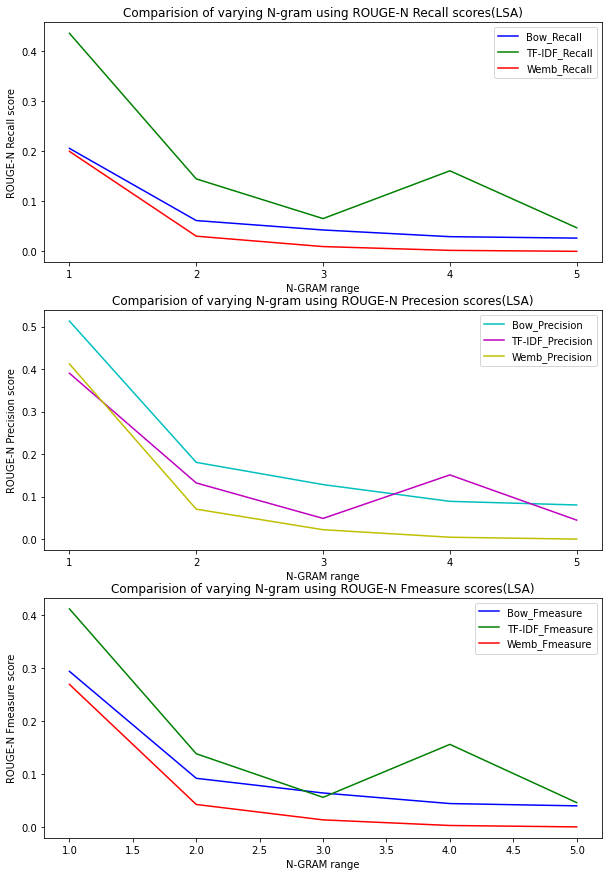

In [159]:
fig, ax = plt.subplots(3,1,figsize=(10,15))

n_gram_range = [i for i in range(1,6)]

ax[0].plot(n_gram_range,lsa_comparision_df["BOW_Recall"],'b-', label="Bow_Recall")
ax[0].plot(n_gram_range,lsa_comparision_df["TF-IDF_Recall"],'g-', label="TF-IDF_Recall")
ax[0].plot(n_gram_range,lsa_comparision_df["W-Emb_Recall"],'r-', label="Wemb_Recall")
ax[0].title.set_text("Comparision of varying N-gram using ROUGE-N Recall scores(LSA)")
ax[0].set_xlabel("N-GRAM range")
ax[0].set_xticks(n_gram_range)
ax[0].set_ylabel("ROUGE-N Recall score")
ax[0].legend(loc="best")

ax[1].plot(n_gram_range,lsa_comparision_df["BOW_Precision"],'c-', label="Bow_Precision")
ax[1].plot(n_gram_range,lsa_comparision_df["TF-IDF_Precision"],'m-', label="TF-IDF_Precision")
ax[1].plot(n_gram_range,lsa_comparision_df["W-Emb_Precision"],'y-', label="Wemb_Precision")
ax[1].title.set_text("Comparision of varying N-gram using ROUGE-N Precesion scores(LSA)")
ax[1].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[1].set_ylabel("ROUGE-N Precision score")
ax[1].legend(loc="best")

ax[2].plot(n_gram_range,lsa_comparision_df["BOW_Fmeasure"],'b-', label="Bow_Fmeasure")
ax[2].plot(n_gram_range,lsa_comparision_df["TF-IDF_Fmeasure"],'g-', label="TF-IDF_Fmeasure")
ax[2].plot(n_gram_range,lsa_comparision_df["W-Emb_Fmeasure"],'r-', label="Wemb_Fmeasure")
ax[2].title.set_text("Comparision of varying N-gram using ROUGE-N Fmeasure scores(LSA)")
ax[2].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[2].set_ylabel("ROUGE-N Fmeasure score")
ax[2].legend(loc="best")

plt.show()

### LDA

In [160]:
lda_comparision_df = pd.DataFrame()
lda_comparision_df["N-Gram Range"] = ["1-Gram", "2-Gram", "3-Gram", "4-Gram", "5-Gram"]

lda_comparision_df["BOW_Recall"] = [bow_lda_1gram_rouge.recall, bow_lda_2gram_rouge.recall, bow_lda_3gram_rouge.recall, bow_lda_4gram_rouge.recall, bow_lda_5gram_rouge.recall]
lda_comparision_df["TF-IDF_Recall"] = [tfidf_lda_1gram_rouge.recall, tfidf_lda_2gram_rouge.recall, tfidf_lda_3gram_rouge.recall, tfidf_lda_4gram_rouge.recall, tfidf_lda_5gram_rouge.recall]
lda_comparision_df["W-Emb_Recall"] = [wemb_lsa_1gram_rouge.recall, wemb_lda_2gram_rouge.recall, wemb_lda_3gram_rouge.recall, wemb_lda_4gram_rouge.recall, wemb_lda_5gram_rouge.recall]

lda_comparision_df["BOW_Precision"] = [bow_lda_1gram_rouge.precision, bow_lda_2gram_rouge.precision, bow_lda_3gram_rouge.precision, bow_lda_4gram_rouge.precision, bow_lda_5gram_rouge.precision]
lda_comparision_df["TF-IDF_Precision"] = [tfidf_lda_1gram_rouge.precision, tfidf_lda_2gram_rouge.precision, tfidf_lda_3gram_rouge.precision, tfidf_lda_4gram_rouge.precision, tfidf_lda_5gram_rouge.precision]
lda_comparision_df["W-Emb_Precision"] = [wemb_lda_1gram_rouge.precision, wemb_lda_2gram_rouge.precision, wemb_lda_3gram_rouge.precision, wemb_lda_4gram_rouge.precision, wemb_lda_5gram_rouge.precision]

lda_comparision_df["BOW_Fmeasure"] = [bow_lda_1gram_rouge.fmeasure, bow_lda_2gram_rouge.fmeasure, bow_lda_3gram_rouge.fmeasure, bow_lda_4gram_rouge.fmeasure, bow_lda_5gram_rouge.fmeasure]
lda_comparision_df["TF-IDF_Fmeasure"] = [tfidf_lda_1gram_rouge.fmeasure, tfidf_lda_2gram_rouge.fmeasure, tfidf_lda_3gram_rouge.fmeasure, tfidf_lda_4gram_rouge.fmeasure, tfidf_lda_5gram_rouge.fmeasure]
lda_comparision_df["W-Emb_Fmeasure"] = [wemb_lda_1gram_rouge.fmeasure, wemb_lda_2gram_rouge.fmeasure, wemb_lda_3gram_rouge.fmeasure, wemb_lda_4gram_rouge.fmeasure, wemb_lda_5gram_rouge.fmeasure]

lda_comparision_df

,N-Gram Range,BOW_Recall,TF-IDF_Recall,W-Emb_Recall,BOW_Precision,TF-IDF_Precision,W-Emb_Precision,BOW_Fmeasure,TF-IDF_Fmeasure,W-Emb_Fmeasure
0,1-Gram,0.200972,0.169675,0.200000,0.543860,0.412281,0.407895,0.293491,0.240409,0.256552
1,2-Gram,0.068006,0.043333,0.020000,0.193833,0.114537,0.030837,0.100686,0.062878,0.024263
2,3-Gram,0.041221,0.008264,0.008596,0.119469,0.022124,0.013274,0.061294,0.012034,0.010435
3,4-Gram,0.030030,0.030303,0.002874,0.088889,0.088889,0.004444,0.044893,0.045198,0.003490
4,5-Gram,0.027439,0.028571,0.000000,0.080357,0.080357,0.000000,0.040909,0.042155,0.000000


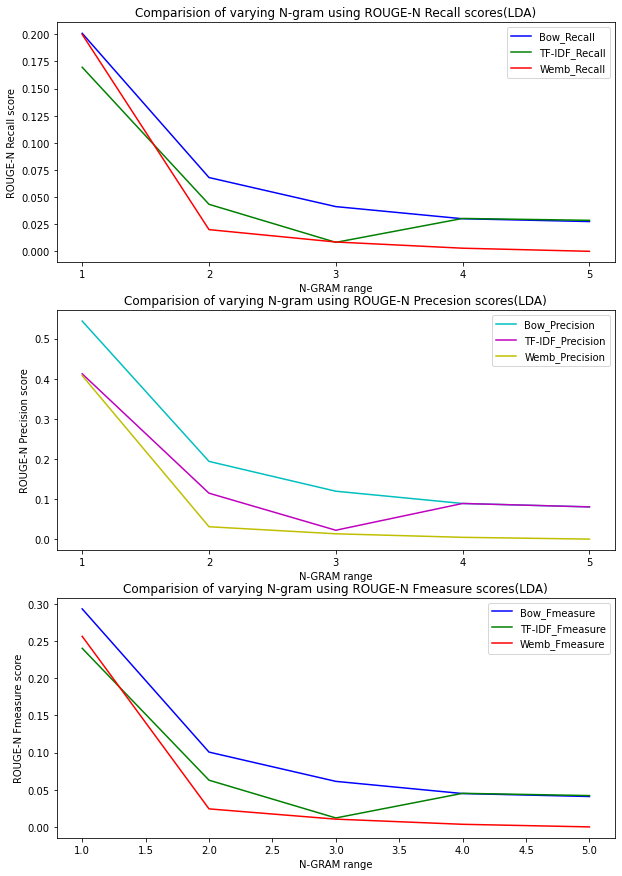

In [161]:
fig, ax = plt.subplots(3,1,figsize=(10,15))

n_gram_range = [i for i in range(1,6)]

ax[0].plot(n_gram_range,lda_comparision_df["BOW_Recall"],'b-', label="Bow_Recall")
ax[0].plot(n_gram_range,lda_comparision_df["TF-IDF_Recall"],'g-', label="TF-IDF_Recall")
ax[0].plot(n_gram_range,lda_comparision_df["W-Emb_Recall"],'r-', label="Wemb_Recall")
ax[0].title.set_text("Comparision of varying N-gram using ROUGE-N Recall scores(LDA)")
ax[0].set_xlabel("N-GRAM range")
ax[0].set_xticks(n_gram_range)
ax[0].set_ylabel("ROUGE-N Recall score")
ax[0].legend(loc="best")

ax[1].plot(n_gram_range,lda_comparision_df["BOW_Precision"],'c-', label="Bow_Precision")
ax[1].plot(n_gram_range,lda_comparision_df["TF-IDF_Precision"],'m-', label="TF-IDF_Precision")
ax[1].plot(n_gram_range,lda_comparision_df["W-Emb_Precision"],'y-', label="Wemb_Precision")
ax[1].title.set_text("Comparision of varying N-gram using ROUGE-N Precesion scores(LDA)")
ax[1].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[1].set_ylabel("ROUGE-N Precision score")
ax[1].legend(loc="best")

ax[2].plot(n_gram_range,lda_comparision_df["BOW_Fmeasure"],'b-', label="Bow_Fmeasure")
ax[2].plot(n_gram_range,lda_comparision_df["TF-IDF_Fmeasure"],'g-', label="TF-IDF_Fmeasure")
ax[2].plot(n_gram_range,lda_comparision_df["W-Emb_Fmeasure"],'r-', label="Wemb_Fmeasure")
ax[2].title.set_text("Comparision of varying N-gram using ROUGE-N Fmeasure scores(LDA)")
ax[2].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[2].set_ylabel("ROUGE-N Fmeasure score")
ax[2].legend(loc="best")

plt.show()

### K-Means

#### LSA

In [162]:
klsa_comparision_df = pd.DataFrame()
klsa_comparision_df["N-Gram Range"] = ["1-Gram", "2-Gram", "3-Gram", "4-Gram", "5-Gram"]


klsa_comparision_df["BOW_Recall"] = [bow_lsa_kmeans_1gram_rouge.recall,
                                     bow_lsa_kmeans_2gram_rouge.recall, 
                                     bow_lsa_kmeans_3gram_rouge.recall, 
                                     bow_lsa_kmeans_4gram_rouge.recall, 
                                     bow_lsa_kmeans_5gram_rouge.recall]

klsa_comparision_df["TF-IDF_Recall"] = [tfidf_lsa_kmeans_1gram_rouge.recall, 
                                        tfidf_lsa_kmeans_2gram_rouge.recall, 
                                        tfidf_lsa_kmeans_3gram_rouge.recall, 
                                        tfidf_lsa_kmeans_4gram_rouge.recall, 
                                        tfidf_lsa_kmeans_5gram_rouge.recall]

klsa_comparision_df["W-Emb_Recall"] = [wemb_lsa_kmeans_1gram_rouge.recall, 
                                       wemb_lsa_kmeans_2gram_rouge.recall, 
                                       wemb_lsa_kmeans_3gram_rouge.recall, 
                                       wemb_lsa_kmeans_4gram_rouge.recall, 
                                       wemb_lsa_kmeans_5gram_rouge.recall]




klsa_comparision_df["BOW_Precision"] = [bow_lsa_kmeans_1gram_rouge.precision, 
                                        bow_lsa_kmeans_2gram_rouge.precision, 
                                        bow_lsa_kmeans_3gram_rouge.precision, 
                                        bow_lsa_kmeans_4gram_rouge.precision, 
                                        bow_lsa_kmeans_5gram_rouge.precision]

klsa_comparision_df["TF-IDF_Precision"] = [tfidf_lsa_kmeans_1gram_rouge.precision, 
                                           tfidf_lsa_kmeans_2gram_rouge.precision, 
                                           tfidf_lsa_kmeans_3gram_rouge.precision, 
                                           tfidf_lsa_kmeans_4gram_rouge.precision, 
                                           tfidf_lsa_kmeans_5gram_rouge.precision]

klsa_comparision_df["W-Emb_Precision"] = [wemb_lsa_kmeans_1gram_rouge.precision, 
                                          wemb_lsa_kmeans_2gram_rouge.precision, 
                                          wemb_lsa_kmeans_3gram_rouge.precision, 
                                          wemb_lsa_kmeans_4gram_rouge.precision, 
                                          wemb_lsa_kmeans_5gram_rouge.precision]




klsa_comparision_df["BOW_Fmeasure"] = [bow_lsa_kmeans_1gram_rouge.fmeasure, 
                                       bow_lsa_kmeans_2gram_rouge.fmeasure, 
                                       bow_lsa_kmeans_3gram_rouge.fmeasure, 
                                       bow_lsa_kmeans_4gram_rouge.fmeasure, 
                                       bow_lsa_kmeans_5gram_rouge.fmeasure]

klsa_comparision_df["TF-IDF_Fmeasure"] = [tfidf_lsa_kmeans_1gram_rouge.fmeasure, 
                                          tfidf_lsa_kmeans_2gram_rouge.fmeasure, 
                                          tfidf_lsa_kmeans_3gram_rouge.fmeasure, 
                                          tfidf_lsa_kmeans_4gram_rouge.fmeasure, 
                                          tfidf_lsa_kmeans_5gram_rouge.fmeasure]

klsa_comparision_df["W-Emb_Fmeasure"] = [wemb_lsa_kmeans_1gram_rouge.fmeasure, 
                                         wemb_lsa_kmeans_2gram_rouge.fmeasure, 
                                         wemb_lsa_kmeans_3gram_rouge.fmeasure, 
                                         wemb_lsa_kmeans_4gram_rouge.fmeasure, 
                                         wemb_lsa_kmeans_5gram_rouge.fmeasure]

klsa_comparision_df

,N-Gram Range,BOW_Recall,TF-IDF_Recall,W-Emb_Recall,BOW_Precision,TF-IDF_Precision,W-Emb_Precision,BOW_Fmeasure,TF-IDF_Fmeasure,W-Emb_Fmeasure
0,1-Gram,0.278607,0.329167,0.280528,0.491228,0.346491,0.372807,0.355556,0.337607,0.320151
1,2-Gram,0.070707,0.058824,0.070485,0.185022,0.074890,0.070485,0.102314,0.065891,0.070485
2,3-Gram,0.041221,0.023585,0.026549,0.119469,0.022124,0.026549,0.061294,0.022831,0.026549
3,4-Gram,0.029762,0.154206,0.004444,0.088889,0.146667,0.004444,0.044593,0.150342,0.004444
4,5-Gram,0.026826,0.041284,0.000000,0.080357,0.040179,0.000000,0.040223,0.040724,0.000000


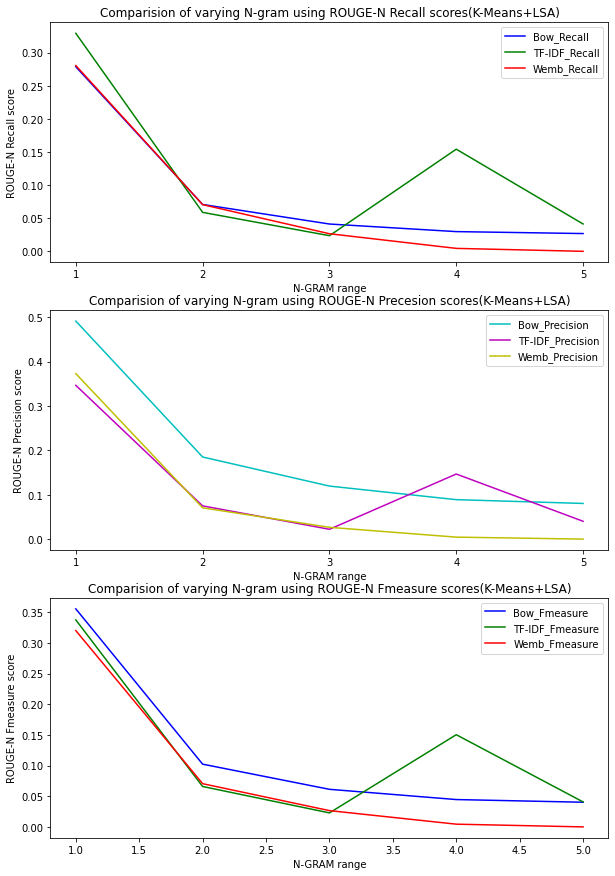

In [163]:
fig, ax = plt.subplots(3,1,figsize=(10,15))

n_gram_range = [i for i in range(1,6)]

ax[0].plot(n_gram_range,klsa_comparision_df["BOW_Recall"],'b-', label="Bow_Recall")
ax[0].plot(n_gram_range,klsa_comparision_df["TF-IDF_Recall"],'g-', label="TF-IDF_Recall")
ax[0].plot(n_gram_range,klsa_comparision_df["W-Emb_Recall"],'r-', label="Wemb_Recall")
ax[0].title.set_text("Comparision of varying N-gram using ROUGE-N Recall scores(K-Means+LSA)")
ax[0].set_xlabel("N-GRAM range")
ax[0].set_xticks(n_gram_range)
ax[0].set_ylabel("ROUGE-N Recall score")
ax[0].legend(loc="best")

ax[1].plot(n_gram_range,klsa_comparision_df["BOW_Precision"],'c-', label="Bow_Precision")
ax[1].plot(n_gram_range,klsa_comparision_df["TF-IDF_Precision"],'m-', label="TF-IDF_Precision")
ax[1].plot(n_gram_range,klsa_comparision_df["W-Emb_Precision"],'y-', label="Wemb_Precision")
ax[1].title.set_text("Comparision of varying N-gram using ROUGE-N Precesion scores(K-Means+LSA)")
ax[1].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[1].set_ylabel("ROUGE-N Precision score")
ax[1].legend(loc="best")

ax[2].plot(n_gram_range,klsa_comparision_df["BOW_Fmeasure"],'b-', label="Bow_Fmeasure")
ax[2].plot(n_gram_range,klsa_comparision_df["TF-IDF_Fmeasure"],'g-', label="TF-IDF_Fmeasure")
ax[2].plot(n_gram_range,klsa_comparision_df["W-Emb_Fmeasure"],'r-', label="Wemb_Fmeasure")
ax[2].title.set_text("Comparision of varying N-gram using ROUGE-N Fmeasure scores(K-Means+LSA)")
ax[2].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[2].set_ylabel("ROUGE-N Fmeasure score")
ax[2].legend(loc="best")

plt.show()

#### LDA

In [164]:
klda_comparision_df = pd.DataFrame()
klda_comparision_df["N-Gram Range"] = ["1-Gram", "2-Gram", "3-Gram", "4-Gram", "5-Gram"]


klda_comparision_df["BOW_Recall"] = [bow_lda_kmeans_1gram_rouge.recall,
                                     bow_lda_kmeans_2gram_rouge.recall, 
                                     bow_lda_kmeans_3gram_rouge.recall, 
                                     bow_lda_kmeans_4gram_rouge.recall, 
                                     bow_lda_kmeans_5gram_rouge.recall]

klda_comparision_df["TF-IDF_Recall"] = [tfidf_lda_kmeans_1gram_rouge.recall, 
                                        tfidf_lda_kmeans_2gram_rouge.recall, 
                                        tfidf_lda_kmeans_3gram_rouge.recall, 
                                        tfidf_lda_kmeans_4gram_rouge.recall, 
                                        tfidf_lda_kmeans_5gram_rouge.recall]

klda_comparision_df["W-Emb_Recall"] = [wemb_lda_kmeans_1gram_rouge.recall, 
                                       wemb_lda_kmeans_2gram_rouge.recall, 
                                       wemb_lda_kmeans_3gram_rouge.recall, 
                                       wemb_lda_kmeans_4gram_rouge.recall, 
                                       wemb_lda_kmeans_5gram_rouge.recall]




klda_comparision_df["BOW_Precision"] = [bow_lda_kmeans_1gram_rouge.precision, 
                                        bow_lda_kmeans_2gram_rouge.precision, 
                                        bow_lda_kmeans_3gram_rouge.precision, 
                                        bow_lda_kmeans_4gram_rouge.precision, 
                                        bow_lda_kmeans_5gram_rouge.precision]

klda_comparision_df["TF-IDF_Precision"] = [tfidf_lda_kmeans_1gram_rouge.precision, 
                                           tfidf_lda_kmeans_2gram_rouge.precision, 
                                           tfidf_lda_kmeans_3gram_rouge.precision, 
                                           tfidf_lda_kmeans_4gram_rouge.precision, 
                                           tfidf_lda_kmeans_5gram_rouge.precision]

klda_comparision_df["W-Emb_Precision"] = [wemb_lda_kmeans_1gram_rouge.precision, 
                                          wemb_lda_kmeans_2gram_rouge.precision, 
                                          wemb_lda_kmeans_3gram_rouge.precision, 
                                          wemb_lda_kmeans_4gram_rouge.precision, 
                                          wemb_lda_kmeans_5gram_rouge.precision]




klda_comparision_df["BOW_Fmeasure"] = [bow_lda_kmeans_1gram_rouge.fmeasure, 
                                       bow_lda_kmeans_2gram_rouge.fmeasure, 
                                       bow_lda_kmeans_3gram_rouge.fmeasure, 
                                       bow_lda_kmeans_4gram_rouge.fmeasure, 
                                       bow_lda_kmeans_5gram_rouge.fmeasure]

klda_comparision_df["TF-IDF_Fmeasure"] = [tfidf_lda_kmeans_1gram_rouge.fmeasure, 
                                          tfidf_lda_kmeans_2gram_rouge.fmeasure, 
                                          tfidf_lda_kmeans_3gram_rouge.fmeasure, 
                                          tfidf_lda_kmeans_4gram_rouge.fmeasure, 
                                          tfidf_lda_kmeans_5gram_rouge.fmeasure]

klda_comparision_df["W-Emb_Fmeasure"] = [wemb_lda_kmeans_1gram_rouge.fmeasure, 
                                         wemb_lda_kmeans_2gram_rouge.fmeasure, 
                                         wemb_lda_kmeans_3gram_rouge.fmeasure, 
                                         wemb_lda_kmeans_4gram_rouge.fmeasure, 
                                         wemb_lda_kmeans_5gram_rouge.fmeasure]

klda_comparision_df

,N-Gram Range,BOW_Recall,TF-IDF_Recall,W-Emb_Recall,BOW_Precision,TF-IDF_Precision,W-Emb_Precision,BOW_Fmeasure,TF-IDF_Fmeasure,W-Emb_Fmeasure
0,1-Gram,0.420765,0.289474,0.280576,0.337719,0.289474,0.342105,0.374696,0.289474,0.308300
1,2-Gram,0.020833,0.109170,0.061856,0.017621,0.110132,0.079295,0.019093,0.109649,0.069498
2,3-Gram,0.028708,0.096330,0.017241,0.026549,0.092920,0.022124,0.027586,0.094595,0.019380
3,4-Gram,0.000000,0.004505,0.003460,0.000000,0.004444,0.004444,0.000000,0.004474,0.003891
4,5-Gram,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


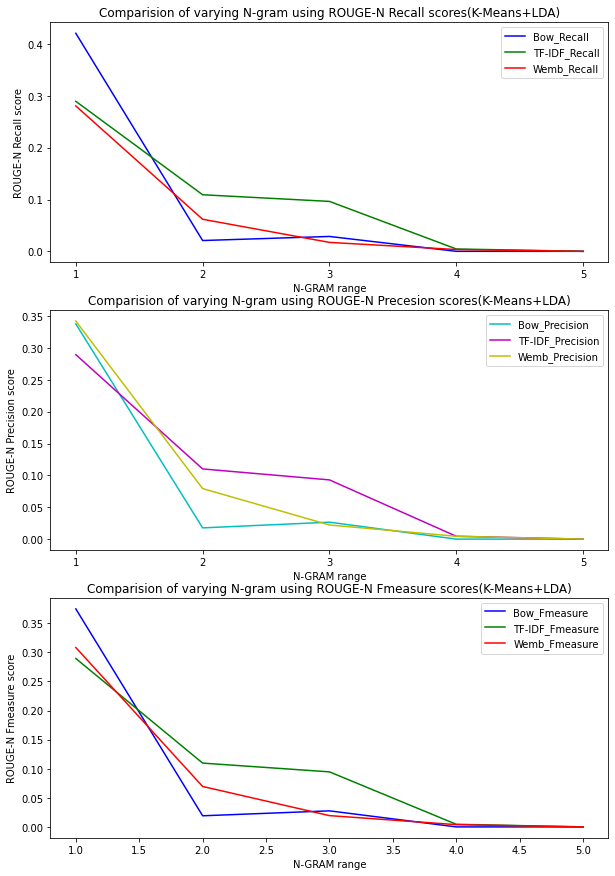

In [165]:
fig, ax = plt.subplots(3,1,figsize=(10,15))

n_gram_range = [i for i in range(1,6)]

ax[0].plot(n_gram_range,klda_comparision_df["BOW_Recall"],'b-', label="Bow_Recall")
ax[0].plot(n_gram_range,klda_comparision_df["TF-IDF_Recall"],'g-', label="TF-IDF_Recall")
ax[0].plot(n_gram_range,klda_comparision_df["W-Emb_Recall"],'r-', label="Wemb_Recall")
ax[0].title.set_text("Comparision of varying N-gram using ROUGE-N Recall scores(K-Means+LDA)")
ax[0].set_xlabel("N-GRAM range")
ax[0].set_xticks(n_gram_range)
ax[0].set_ylabel("ROUGE-N Recall score")
ax[0].legend(loc="best")

ax[1].plot(n_gram_range,klda_comparision_df["BOW_Precision"],'c-', label="Bow_Precision")
ax[1].plot(n_gram_range,klda_comparision_df["TF-IDF_Precision"],'m-', label="TF-IDF_Precision")
ax[1].plot(n_gram_range,klda_comparision_df["W-Emb_Precision"],'y-', label="Wemb_Precision")
ax[1].title.set_text("Comparision of varying N-gram using ROUGE-N Precesion scores(K-Means+LDA)")
ax[1].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[1].set_ylabel("ROUGE-N Precision score")
ax[1].legend(loc="best")

ax[2].plot(n_gram_range,klda_comparision_df["BOW_Fmeasure"],'b-', label="Bow_Fmeasure")
ax[2].plot(n_gram_range,klda_comparision_df["TF-IDF_Fmeasure"],'g-', label="TF-IDF_Fmeasure")
ax[2].plot(n_gram_range,klda_comparision_df["W-Emb_Fmeasure"],'r-', label="Wemb_Fmeasure")
ax[2].title.set_text("Comparision of varying N-gram using ROUGE-N Fmeasure scores(K-Means+LDA)")
ax[2].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[2].set_ylabel("ROUGE-N Fmeasure score")
ax[2].legend(loc="best")

plt.show()

## Overall F Measure Comparision

In [168]:
fm_comparision_df = pd.DataFrame()

fm_comparision_df["LSA_TF-IDF_Fmeasure"] = [tfidf_lsa_1gram_rouge.fmeasure, tfidf_lsa_2gram_rouge.fmeasure, tfidf_lsa_3gram_rouge.fmeasure, tfidf_lsa_4gram_rouge.fmeasure, tfidf_lsa_5gram_rouge.fmeasure]
fm_comparision_df["LDA_BOW_Fmeasure"] = [bow_lda_1gram_rouge.fmeasure, bow_lda_2gram_rouge.fmeasure, bow_lda_3gram_rouge.fmeasure, bow_lda_4gram_rouge.fmeasure, bow_lda_5gram_rouge.fmeasure]

fm_comparision_df["LSA_KM_BOW_Fmeasure"] = [bow_lsa_kmeans_1gram_rouge.fmeasure, bow_lsa_kmeans_2gram_rouge.fmeasure, bow_lsa_kmeans_3gram_rouge.fmeasure, bow_lsa_kmeans_4gram_rouge.fmeasure, bow_lsa_kmeans_5gram_rouge.fmeasure]

fm_comparision_df["LDA_KM_BOW_Fmeasure"] = [bow_lda_kmeans_1gram_rouge.fmeasure, bow_lda_kmeans_2gram_rouge.fmeasure, bow_lda_kmeans_3gram_rouge.fmeasure, bow_lda_kmeans_4gram_rouge.fmeasure, bow_lda_kmeans_5gram_rouge.fmeasure]

fm_comparision_df

,LSA_TF-IDF_Fmeasure,LDA_BOW_Fmeasure,LSA_KM_BOW_Fmeasure,LDA_KM_BOW_Fmeasure
0,0.412037,0.293491,0.355556,0.374696
1,0.138249,0.100686,0.102314,0.019093
2,0.055838,0.061294,0.061294,0.027586
3,0.155963,0.044893,0.044593,0.000000
4,0.045872,0.040909,0.040223,0.000000


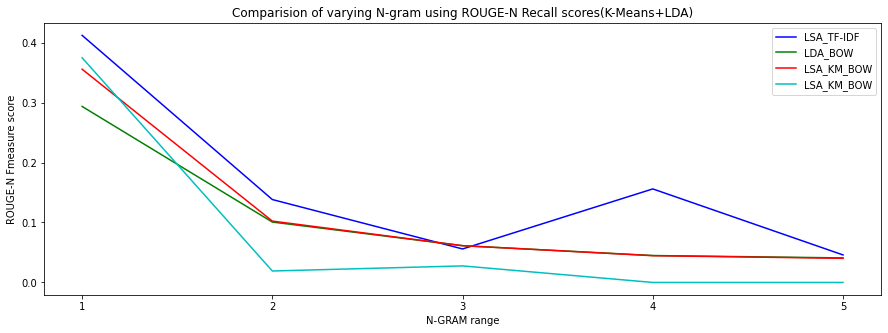

In [177]:
fig, ax = plt.subplots(1,1,figsize=(15,5))

n_gram_range = [i for i in range(1,6)]

ax.plot(n_gram_range,fm_comparision_df["LSA_TF-IDF_Fmeasure"],'b-', label="LSA_TF-IDF")
ax.plot(n_gram_range,fm_comparision_df["LDA_BOW_Fmeasure"],'g-', label="LDA_BOW")
ax.plot(n_gram_range,fm_comparision_df["LSA_KM_BOW_Fmeasure"],'r-', label="LSA_KM_BOW")
ax.plot(n_gram_range,fm_comparision_df["LDA_KM_BOW_Fmeasure"],'c-', label="LSA_KM_BOW")

ax.title.set_text("Comparision of varying N-gram using ROUGE-N Recall scores(K-Means+LDA)")
ax.set_xlabel("N-GRAM range")
ax.set_xticks(n_gram_range)
ax.set_ylabel("ROUGE-N Fmeasure score")
ax.legend(loc="best")

plt.show()